# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.

In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 200 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(4) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

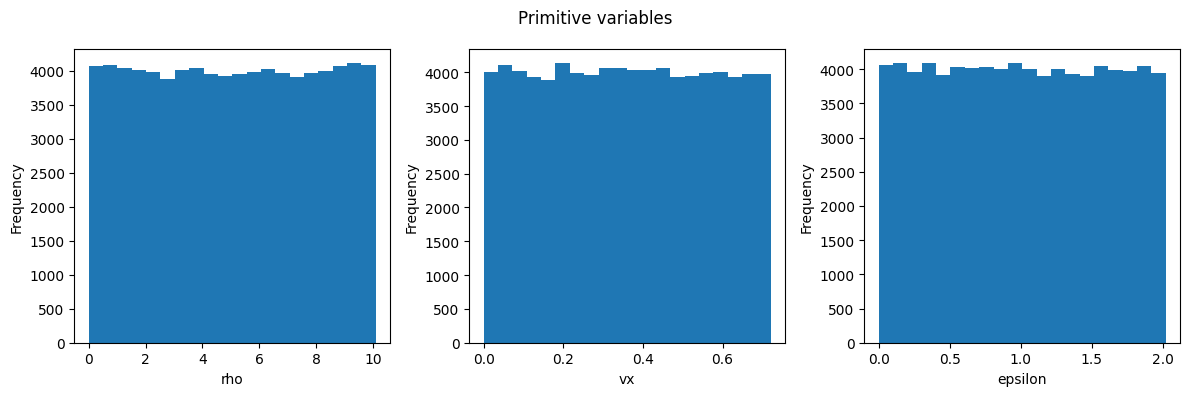

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([3.7178, 2.2458, 6.2395,  ..., 1.1359, 2.7856, 0.9368], device='cuda:0')

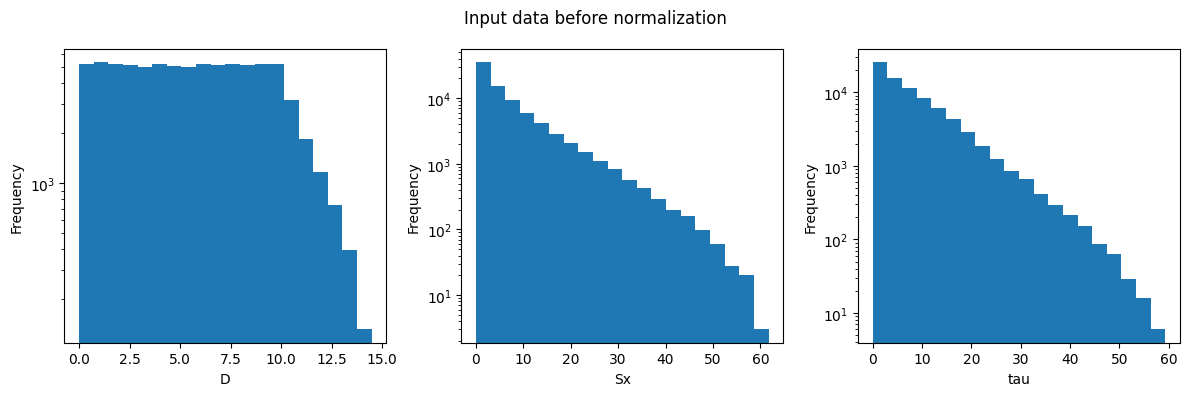

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:

# # Computing the mean and standard deviation of each input variable from the training set
# D_mean = torch.mean(x_train[:, 0])
# D_std = torch.std(x_train[:, 0])
# Sx_mean = torch.mean(x_train[:, 1])
# Sx_std = torch.std(x_train[:, 1])
# tau_mean = torch.mean(x_train[:, 2])
# tau_std = torch.std(x_train[:, 2])

# # Applying z-score normalization to both train and test sets using the statistics from the training set
# x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
# x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
# x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
# x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
# x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
# x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(5.6435, device='cuda:0')
tensor(3.3454, device='cuda:0')
tensor(6.8819, device='cuda:0')
tensor(8.1340, device='cuda:0')
tensor(8.0449, device='cuda:0')
tensor(7.8764, device='cuda:0')


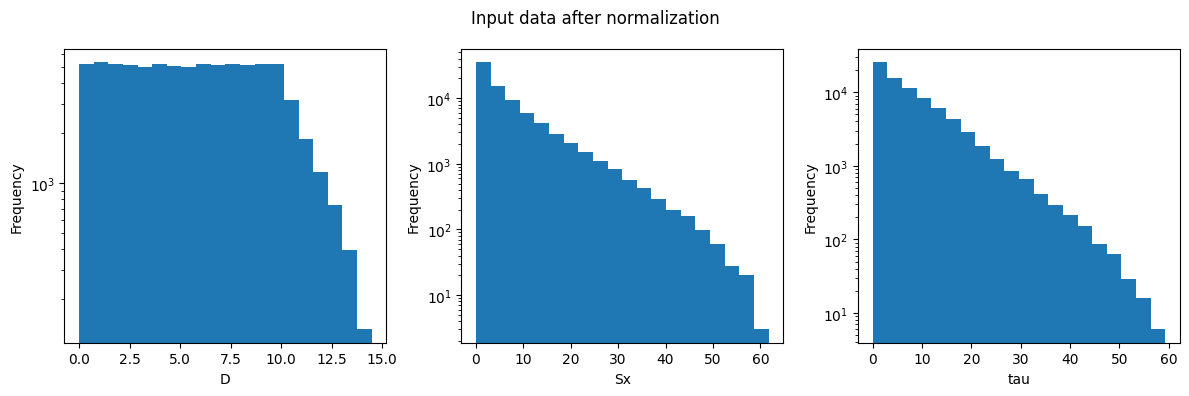

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


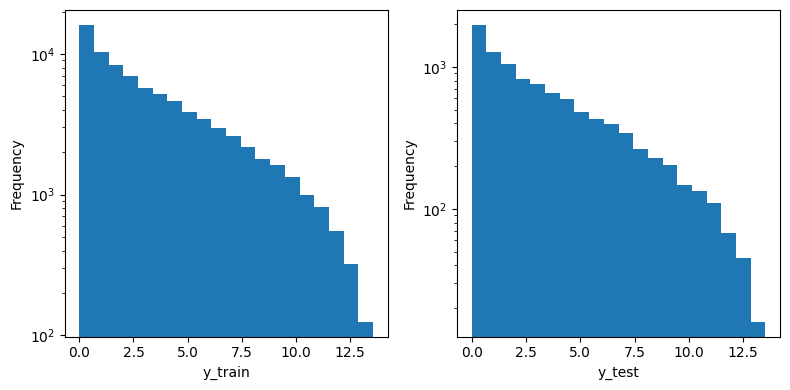

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 3)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            "loss", ["MSE", "MAE", "Huber", "LogCosh"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 256)
        n_epochs = trial.suggest_int("n_epochs", 10, 200) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR","OneCycleLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        # Added sampling the weight decay and momentum for SGD
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
        momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
        optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optimizer_name == "Adam":
        # Added sampling the weight decay and beta parameters for Adam
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
        beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
        beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=lr)
    else:
        # Added creating the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        # Added sampling the step_size and gamma for StepLR
        step_size = trial.suggest_int("step_size", 5, 15)
        gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == "ExponentialLR":
        # Added sampling the gamma for ExponentialLR
        gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_name == "CosineAnnealingLR":
        # Added sampling the T_max for CosineAnnealingLR
        T_max = trial.suggest_int("T_max", 5, 15)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
    elif scheduler_name == "ReduceLROnPlateau":
        # Added sampling the factor, patience and threshold for ReduceLROnPlateau
        factor = trial.suggest_uniform("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 5, 15)
        threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
        )
    # # Added using OneCycleLR scheduler as an option
    # elif scheduler_name == "OneCycleLR":
    #         # Added sampling the max_lr and pct_start for OneCycleLR
    #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
    #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
    #         scheduler = optim.lr_scheduler.OneCycleLR(
    #             optimizer,
    #             max_lr=max_lr,
    #             epochs=n_epochs,
    #             steps_per_epoch=len(train_loader),
    #             pct_start=pct_start,
    #         )
    else:
        scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-14 11:30:34,150] A new study created in memory with name: no-name-10a8ef05-1f56-44d3-978a-2ea81640a346
<ipython-input-59-d4ca07a22bfc>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-59-d4ca07a22bfc>:112: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-59-d4ca07a22bfc>:113: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  mom

Epoch 1: Train Loss: 0.1558, Test Loss: 0.0282, Train L1 Norm: 5.2583, Test L1 Norm: 3.0869, Train Linf Norm: 109.4276, Test Linf Norm: 64.0458
Epoch 2: Train Loss: 0.0211, Test Loss: 0.0162, Train L1 Norm: 4.0590, Test L1 Norm: 2.9351, Train Linf Norm: 85.9637, Test Linf Norm: 61.2421
Epoch 3: Train Loss: 0.0143, Test Loss: 0.0123, Train L1 Norm: 3.8091, Test L1 Norm: 2.8137, Train Linf Norm: 79.7502, Test Linf Norm: 58.8752
Epoch 4: Train Loss: 0.0116, Test Loss: 0.0104, Train L1 Norm: 3.5787, Test L1 Norm: 2.7120, Train Linf Norm: 75.9517, Test Linf Norm: 56.8599
Epoch 5: Train Loss: 0.0099, Test Loss: 0.0092, Train L1 Norm: 3.4082, Test L1 Norm: 2.6242, Train Linf Norm: 72.4110, Test Linf Norm: 55.0943
Epoch 6: Train Loss: 0.0089, Test Loss: 0.0082, Train L1 Norm: 3.2620, Test L1 Norm: 2.5577, Train Linf Norm: 69.3201, Test Linf Norm: 53.7701
Epoch 7: Train Loss: 0.0081, Test Loss: 0.0076, Train L1 Norm: 3.1550, Test L1 Norm: 2.4959, Train Linf Norm: 66.9583, Test Linf Norm: 52.513

[I 2023-05-14 11:37:11,853] Trial 0 finished with value: 2.185002766711917 and parameters: {'n_layers': 3, 'n_units_0': 477, 'n_units_1': 435, 'n_units_2': 725, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'LogCosh', 'optimizer': 'SGD', 'lr': 0.00013395298585734257, 'batch_size': 23, 'n_epochs': 50, 'scheduler': 'StepLR', 'weight_decay': 0.008091838194815433, 'momentum': 0.12022219948227084, 'step_size': 14, 'gamma': 0.09778985777032034}. Best is trial 0 with value: 2.185002766711917.


Epoch 50: Train Loss: 0.0050, Test Loss: 0.0049, Train L1 Norm: 2.5949, Test L1 Norm: 2.1850, Train Linf Norm: 55.1929, Test Linf Norm: 46.1785


<ipython-input-59-d4ca07a22bfc>:135: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 8: Trai

[I 2023-05-14 11:59:43,154] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 2, 'n_units_0': 927, 'n_units_1': 727, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'SGD', 'lr': 0.0002958118390136455, 'batch_size': 17, 'n_epochs': 145, 'scheduler': 'ExponentialLR', 'weight_decay': 0.00031145375888763855, 'momentum': 0.016000712361557257, 'gamma': 0.8432553546797719}. Best is trial 1 with value: 1.0.


Epoch 145: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3340, Test Loss: 0.1172, Train L1 Norm: 5.0279, Test L1 Norm: 2.9740, Train Linf Norm: 929.2649, Test Linf Norm: 541.1802
Epoch 2: Train Loss: 0.0897, Test Loss: 0.0261, Train L1 Norm: 4.0312, Test L1 Norm: 2.8378, Train Linf Norm: 775.2511, Test Linf Norm: 528.7887
Epoch 3: Train Loss: 0.0343, Test Loss: 0.1572, Train L1 Norm: 3.6809, Test L1 Norm: 2.5607, Train Linf Norm: 707.2398, Test Linf Norm: 464.3237
Epoch 4: Train Loss: 0.0284, Test Loss: 0.0163, Train L1 Norm: 3.4695, Test L1 Norm: 2.7213, Train Linf Norm: 622.9084, Test Linf Norm: 517.7378
Epoch 5: Train Loss: 0.0206, Test Loss: 0.0103, Train L1 Norm: 3.2561, Test L1 Norm: 2.5833, Train Linf Norm: 598.4866, Test Linf Norm: 494.3331
Epoch 6: Train Loss: 0.0125, Test Loss: 0.0275, Train L1 Norm: 3.1091, Test L1 Norm: 2.4025, Train Linf Norm: 594.9364, Test Linf No

[I 2023-05-14 12:00:08,287] Trial 2 finished with value: 2.086806902372837 and parameters: {'n_layers': 2, 'n_units_0': 268, 'n_units_1': 786, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.0015917410763812573, 'batch_size': 248, 'n_epochs': 19, 'scheduler': 'OneCycleLR', 'weight_decay': 0.0002633163839472179, 'momentum': 0.07565486648828688}. Best is trial 1 with value: 1.0.


Epoch 19: Train Loss: 0.0060, Test Loss: 0.0130, Train L1 Norm: 2.2528, Test L1 Norm: 2.0868, Train Linf Norm: 425.4863, Test Linf Norm: 410.6135


<ipython-input-59-d4ca07a22bfc>:143: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-59-d4ca07a22bfc>:145: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 3.0362, Test Loss: 2.9773, Train L1 Norm: 1.2518, Test L1 Norm: 0.9995, Train Linf Norm: 17.2294, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9503, Test Loss: 2.9772, Train L1 Norm: 1.0007, Test L1 Norm: 1.0000, Train Linf Norm: 1.2101, Test Linf Norm: 1.1876
Epoch 3: Train Loss: 2.9700, Test Loss: 2.9774, Train L1 Norm: 1.0085, Test L1 Norm: 0.9997, Train Linf Norm: 1.1815, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9842, Test Loss: 2.9774, Train L1 Norm: 1.0159, Test L1 Norm: 1.0000, Train Linf Norm: 1.3262, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9529, Test Loss: 2.9755, Train L1 Norm: 1.0031, Test L1 Norm: 0.9989, Train Linf Norm: 1.1360, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9524, Test Loss: 2.9774, Train L1 Norm: 1.0001, Test L1 Norm: 1.0000, Train Linf Norm: 1.0220, Test Linf Norm: 1.0000
Epoch 8: Tra

[I 2023-05-14 12:03:34,409] Trial 3 finished with value: 0.11888195726890118 and parameters: {'n_layers': 1, 'n_units_0': 544, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.006471778379983815, 'batch_size': 74, 'n_epochs': 94, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.545982637252452, 'patience': 14, 'threshold': 0.0033499949266035793}. Best is trial 3 with value: 0.11888195726890118.


Epoch 94: Train Loss: 0.0053, Test Loss: 0.0004, Train L1 Norm: 0.0788, Test L1 Norm: 0.1189, Train Linf Norm: 4.0051, Test Linf Norm: 7.8284
Epoch 1: Train Loss: 0.2372, Test Loss: 0.1274, Train L1 Norm: 3.8849, Test L1 Norm: 2.5766, Train Linf Norm: 495.6760, Test Linf Norm: 329.8956
Epoch 2: Train Loss: 0.1035, Test Loss: 0.1212, Train L1 Norm: 3.0219, Test L1 Norm: 2.4436, Train Linf Norm: 384.9891, Test Linf Norm: 315.2024
Epoch 3: Train Loss: 0.0887, Test Loss: 0.1017, Train L1 Norm: 2.8292, Test L1 Norm: 2.3388, Train Linf Norm: 362.9044, Test Linf Norm: 302.9570
Epoch 4: Train Loss: 0.0807, Test Loss: 0.0912, Train L1 Norm: 2.7111, Test L1 Norm: 2.2765, Train Linf Norm: 350.5675, Test Linf Norm: 295.9222
Epoch 5: Train Loss: 0.0754, Test Loss: 0.0726, Train L1 Norm: 2.6244, Test L1 Norm: 2.2392, Train Linf Norm: 335.3828, Test Linf Norm: 292.2272
Epoch 6: Train Loss: 0.0710, Test Loss: 0.0670, Train L1 Norm: 2.5443, Test L1 Norm: 2.1909, Train Linf Norm: 327.3743, Test Linf Nor

[I 2023-05-14 12:07:03,782] Trial 4 finished with value: 1.3105429499037564 and parameters: {'n_layers': 2, 'n_units_0': 347, 'n_units_1': 50, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0006115769175605397, 'batch_size': 159, 'n_epochs': 117, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.33429561612706304, 'patience': 7, 'threshold': 0.007681597415202573}. Best is trial 3 with value: 0.11888195726890118.


Epoch 117: Train Loss: 0.0206, Test Loss: 0.0207, Train L1 Norm: 1.4105, Test L1 Norm: 1.3105, Train Linf Norm: 184.7867, Test Linf Norm: 176.7923


<ipython-input-59-d4ca07a22bfc>:117: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-59-d4ca07a22bfc>:118: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
<ipython-input-59-d4ca07a22bfc>:119: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)


Epoch 1: Train Loss: 0.1916, Test Loss: 0.1025, Train L1 Norm: 0.2335, Test L1 Norm: 0.1277, Train Linf Norm: 6.9781, Test Linf Norm: 3.0678
Epoch 2: Train Loss: 0.0834, Test Loss: 0.0690, Train L1 Norm: 0.1645, Test L1 Norm: 0.1031, Train Linf Norm: 5.8601, Test Linf Norm: 2.4469
Epoch 3: Train Loss: 0.0855, Test Loss: 0.0819, Train L1 Norm: 0.1505, Test L1 Norm: 0.1009, Train Linf Norm: 5.1029, Test Linf Norm: 1.3341
Epoch 4: Train Loss: 0.0851, Test Loss: 0.2027, Train L1 Norm: 0.1106, Test L1 Norm: 0.5347, Train Linf Norm: 2.5021, Test Linf Norm: 28.2717
Epoch 5: Train Loss: 0.0849, Test Loss: 0.0773, Train L1 Norm: 0.1431, Test L1 Norm: 0.0891, Train Linf Norm: 4.9175, Test Linf Norm: 1.5280
Epoch 6: Train Loss: 0.0844, Test Loss: 0.0404, Train L1 Norm: 0.1261, Test L1 Norm: 0.0476, Train Linf Norm: 3.5455, Test Linf Norm: 1.2905
Epoch 7: Train Loss: 0.0901, Test Loss: 0.0758, Train L1 Norm: 0.1163, Test L1 Norm: 0.0694, Train Linf Norm: 2.5950, Test Linf Norm: 1.0928
Epoch 8: Tra

[I 2023-05-14 12:11:39,590] Trial 5 finished with value: 0.02577756353840232 and parameters: {'n_layers': 2, 'n_units_0': 138, 'n_units_1': 71, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0028981760687089996, 'batch_size': 80, 'n_epochs': 108, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.004561101425900267, 'beta1': 0.9343122102113666, 'beta2': 0.9382812134576558, 'factor': 0.21271303955399237, 'patience': 6, 'threshold': 0.0026230393601939504}. Best is trial 5 with value: 0.02577756353840232.


Epoch 108: Train Loss: 0.0092, Test Loss: 0.0093, Train L1 Norm: 0.0301, Test L1 Norm: 0.0258, Train Linf Norm: 1.0581, Test Linf Norm: 0.8144
Epoch 1: Train Loss: 0.7151, Test Loss: 0.0116, Train L1 Norm: 0.8212, Test L1 Norm: 0.4202, Train Linf Norm: 24.9960, Test Linf Norm: 13.7528
Epoch 2: Train Loss: 0.0352, Test Loss: 0.0323, Train L1 Norm: 0.3924, Test L1 Norm: 0.3661, Train Linf Norm: 12.5090, Test Linf Norm: 11.5798
Epoch 3: Train Loss: 0.0142, Test Loss: 0.0022, Train L1 Norm: 0.3210, Test L1 Norm: 0.2645, Train Linf Norm: 10.2610, Test Linf Norm: 8.5082
Epoch 4: Train Loss: 0.0074, Test Loss: 0.0010, Train L1 Norm: 0.2799, Test L1 Norm: 0.2652, Train Linf Norm: 9.1526, Test Linf Norm: 8.9399
Epoch 5: Train Loss: 0.0040, Test Loss: 0.0009, Train L1 Norm: 0.2524, Test L1 Norm: 0.2547, Train Linf Norm: 8.2731, Test Linf Norm: 8.5904
Epoch 6: Train Loss: 0.0025, Test Loss: 0.0132, Train L1 Norm: 0.2365, Test L1 Norm: 0.2461, Train Linf Norm: 7.8499, Test Linf Norm: 7.8809
Epoch 

[I 2023-05-14 12:13:16,468] Trial 6 finished with value: 0.16164853193033488 and parameters: {'n_layers': 2, 'n_units_0': 501, 'n_units_1': 932, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00043715980037579435, 'batch_size': 36, 'n_epochs': 21, 'scheduler': 'ExponentialLR', 'gamma': 0.8192801800449905}. Best is trial 5 with value: 0.02577756353840232.


Epoch 21: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.1630, Test L1 Norm: 0.1616, Train Linf Norm: 5.5759, Test Linf Norm: 5.5910


[I 2023-05-14 12:13:19,323] Trial 7 pruned. 


Epoch 1: Train Loss: 0.0422, Test Loss: 0.0092, Train L1 Norm: 3.5094, Test L1 Norm: 2.1321, Train Linf Norm: 216.1248, Test Linf Norm: 130.9485
Epoch 1: Train Loss: 0.1122, Test Loss: 0.1810, Train L1 Norm: 0.5571, Test L1 Norm: 0.3728, Train Linf Norm: 21.9629, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.0539, Test Loss: 0.0104, Train L1 Norm: 0.2777, Test L1 Norm: 0.1089, Train Linf Norm: 5.3108, Test Linf Norm: 1.0131
Epoch 3: Train Loss: 0.0387, Test Loss: 0.0089, Train L1 Norm: 0.5628, Test L1 Norm: 0.0830, Train Linf Norm: 32.8567, Test Linf Norm: 1.3687
Epoch 4: Train Loss: 0.0284, Test Loss: 0.0398, Train L1 Norm: 0.2673, Test L1 Norm: 0.1553, Train Linf Norm: 7.8568, Test Linf Norm: 1.0850
Epoch 5: Train Loss: 0.0201, Test Loss: 0.0056, Train L1 Norm: 0.6611, Test L1 Norm: 0.0739, Train Linf Norm: 45.1386, Test Linf Norm: 1.1321
Epoch 6: Train Loss: 0.0136, Test Loss: 0.0026, Train L1 Norm: 0.2153, Test L1 Norm: 0.0597, Train Linf Norm: 7.0625, Test Linf Norm: 1.1879
Epoch 

[I 2023-05-14 12:17:00,974] Trial 8 finished with value: 0.10073578403890134 and parameters: {'n_layers': 1, 'n_units_0': 543, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.009979258878951836, 'batch_size': 90, 'n_epochs': 106, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 1.3953755881969121e-05, 'beta1': 0.6842972078589464, 'beta2': 0.9266984716952403, 'T_max': 11}. Best is trial 5 with value: 0.02577756353840232.


Epoch 106: Train Loss: 0.0031, Test Loss: 0.0022, Train L1 Norm: 0.1890, Test L1 Norm: 0.1007, Train Linf Norm: 7.6474, Test Linf Norm: 1.0391
Epoch 1: Train Loss: 0.0695, Test Loss: 0.0076, Train L1 Norm: 0.3800, Test L1 Norm: 0.0482, Train Linf Norm: 56.9341, Test Linf Norm: 2.0314
Epoch 2: Train Loss: 0.0033, Test Loss: 0.0021, Train L1 Norm: 0.0661, Test L1 Norm: 0.0449, Train Linf Norm: 8.7187, Test Linf Norm: 4.8248
Epoch 3: Train Loss: 0.0012, Test Loss: 0.0007, Train L1 Norm: 0.0412, Test L1 Norm: 0.0237, Train Linf Norm: 4.4430, Test Linf Norm: 1.0989
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0339, Test L1 Norm: 0.0222, Train Linf Norm: 3.3790, Test Linf Norm: 1.0924
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0305, Test L1 Norm: 0.0204, Train Linf Norm: 2.9685, Test Linf Norm: 0.9932
Epoch 6: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0285, Test L1 Norm: 0.0190, Train Linf Norm: 2.7736, Test Linf Norm: 1.0072
Epoch 7: T

[I 2023-05-14 12:21:58,285] Trial 9 finished with value: 0.007877636802196502 and parameters: {'n_layers': 2, 'n_units_0': 743, 'n_units_1': 315, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00018789171477546116, 'batch_size': 244, 'n_epochs': 200, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 9 with value: 0.007877636802196502.


Epoch 200: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0094, Test L1 Norm: 0.0079, Train Linf Norm: 0.9174, Test Linf Norm: 0.6425
Epoch 1: Train Loss: 0.0763, Test Loss: 0.0021, Train L1 Norm: 0.3713, Test L1 Norm: 0.1864, Train Linf Norm: 59.0653, Test Linf Norm: 37.7502
Epoch 2: Train Loss: 0.0011, Test Loss: 0.0007, Train L1 Norm: 0.0976, Test L1 Norm: 0.0809, Train Linf Norm: 15.8494, Test Linf Norm: 15.2128
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0555, Test L1 Norm: 0.0274, Train Linf Norm: 8.9655, Test Linf Norm: 3.1028
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0430, Test L1 Norm: 0.0374, Train Linf Norm: 6.7654, Test Linf Norm: 5.7280
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0383, Test L1 Norm: 0.0223, Train Linf Norm: 6.1952, Test Linf Norm: 2.4981
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0343, Test L1 Norm: 0.0178, Train Linf Norm: 5.5150, Test Linf Norm: 1.5288
Epoch 7

[I 2023-05-14 12:26:58,122] Trial 10 finished with value: 0.006550250181416049 and parameters: {'n_layers': 3, 'n_units_0': 1031, 'n_units_1': 316, 'n_units_2': 26, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00027497635554443126, 'batch_size': 254, 'n_epochs': 198, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 10 with value: 0.006550250181416049.


Epoch 198: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0114, Test L1 Norm: 0.0066, Train Linf Norm: 1.7642, Test Linf Norm: 0.5874
Epoch 1: Train Loss: 0.1906, Test Loss: 0.0115, Train L1 Norm: 0.3643, Test L1 Norm: 0.0696, Train Linf Norm: 38.3396, Test Linf Norm: 1.0513
Epoch 2: Train Loss: 0.0052, Test Loss: 0.0047, Train L1 Norm: 0.0706, Test L1 Norm: 0.1782, Train Linf Norm: 6.4909, Test Linf Norm: 34.9886
Epoch 3: Train Loss: 0.0017, Test Loss: 0.0012, Train L1 Norm: 0.0602, Test L1 Norm: 0.1122, Train Linf Norm: 7.4495, Test Linf Norm: 21.5754
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0007, Train L1 Norm: 0.0549, Test L1 Norm: 0.1165, Train Linf Norm: 6.9216, Test Linf Norm: 23.4436
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0482, Test L1 Norm: 0.0894, Train Linf Norm: 6.0912, Test Linf Norm: 17.2202
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0441, Test L1 Norm: 0.0850, Train Linf Norm: 5.7342, Test Linf Norm: 16.5986
Epoch

[I 2023-05-14 12:30:07,617] Trial 11 pruned. 


Epoch 125: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0126, Test L1 Norm: 0.0095, Train Linf Norm: 1.4895, Test Linf Norm: 0.8484
Epoch 1: Train Loss: 0.0504, Test Loss: 0.0005, Train L1 Norm: 0.2424, Test L1 Norm: 0.2087, Train Linf Norm: 29.0900, Test Linf Norm: 37.8057
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0002, Train L1 Norm: 0.0692, Test L1 Norm: 0.1515, Train Linf Norm: 9.6640, Test Linf Norm: 27.6704
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0485, Test L1 Norm: 0.1044, Train Linf Norm: 6.7487, Test Linf Norm: 18.8178
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0004, Train L1 Norm: 0.0426, Test L1 Norm: 0.1133, Train Linf Norm: 6.0393, Test Linf Norm: 20.3378
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0375, Test L1 Norm: 0.1052, Train Linf Norm: 5.3329, Test Linf Norm: 19.1012
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0336, Test L1 Norm: 0.0868, Train Linf Norm: 4.8256, Test Linf Norm: 15.8103
Epoc

[I 2023-05-14 12:33:28,182] Trial 12 pruned. 


Epoch 118: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0120, Test L1 Norm: 0.0189, Train Linf Norm: 1.5867, Test Linf Norm: 3.0659
Epoch 1: Train Loss: 0.1945, Test Loss: 0.0093, Train L1 Norm: 0.6260, Test L1 Norm: 0.2807, Train Linf Norm: 74.8092, Test Linf Norm: 45.7296
Epoch 2: Train Loss: 0.0047, Test Loss: 0.0027, Train L1 Norm: 0.1057, Test L1 Norm: 0.2131, Train Linf Norm: 11.8880, Test Linf Norm: 37.6838
Epoch 3: Train Loss: 0.0017, Test Loss: 0.0012, Train L1 Norm: 0.1106, Test L1 Norm: 0.1751, Train Linf Norm: 15.5175, Test Linf Norm: 30.8910
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0007, Train L1 Norm: 0.0879, Test L1 Norm: 0.1243, Train Linf Norm: 12.0411, Test Linf Norm: 21.1720
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.0683, Test L1 Norm: 0.1034, Train Linf Norm: 8.8715, Test Linf Norm: 17.2569
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0479, Test L1 Norm: 0.0973, Train Linf Norm: 5.3081, Test Linf Norm: 16.0962
E

[I 2023-05-14 12:36:44,342] Trial 13 pruned. 


Epoch 118: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0096, Test L1 Norm: 0.0251, Train Linf Norm: 0.8767, Test Linf Norm: 4.2424


[I 2023-05-14 12:36:45,614] Trial 14 pruned. 


Epoch 1: Train Loss: 5.6853, Test Loss: 3.8828, Train L1 Norm: 3.5607, Test L1 Norm: 7.2997, Train Linf Norm: 419.5216, Test Linf Norm: 1228.9056


[I 2023-05-14 12:36:47,507] Trial 15 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 12:36:48,986] Trial 16 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2242, Test Loss: 0.0018, Train L1 Norm: 0.5267, Test L1 Norm: 0.0603, Train Linf Norm: 46.4385, Test Linf Norm: 1.8655
Epoch 2: Train Loss: 0.0026, Test Loss: 0.0005, Train L1 Norm: 0.0775, Test L1 Norm: 0.0416, Train Linf Norm: 5.4818, Test Linf Norm: 2.0844
Epoch 3: Train Loss: 0.0016, Test Loss: 0.0004, Train L1 Norm: 0.0506, Test L1 Norm: 0.0303, Train Linf Norm: 2.9374, Test Linf Norm: 1.2580
Epoch 4: Train Loss: 0.0017, Test Loss: 0.0004, Train L1 Norm: 0.0553, Test L1 Norm: 0.0298, Train Linf Norm: 4.7547, Test Linf Norm: 1.0642
Epoch 5: Train Loss: 0.0021, Test Loss: 0.0001, Train L1 Norm: 0.0376, Test L1 Norm: 0.0233, Train Linf Norm: 1.7267, Test Linf Norm: 1.2050
Epoch 6: Train Loss: 0.0015, Test Loss: 0.0002, Train L1 Norm: 0.0382, Test L1 Norm: 0.0254, Train Linf Norm: 2.0260, Test Linf Norm: 1.2028
Epoch 7: Tra

[I 2023-05-14 12:39:44,639] Trial 17 pruned. 


Epoch 118: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0271, Test L1 Norm: 0.0222, Train Linf Norm: 1.8034, Test Linf Norm: 1.2579
Epoch 1: Train Loss: 0.3514, Test Loss: 0.1428, Train L1 Norm: 0.2590, Test L1 Norm: 0.2946, Train Linf Norm: 10.4122, Test Linf Norm: 25.6568
Epoch 2: Train Loss: 0.1629, Test Loss: 0.2334, Train L1 Norm: 0.1413, Test L1 Norm: 0.0967, Train Linf Norm: 7.2821, Test Linf Norm: 0.8247
Epoch 3: Train Loss: 0.1180, Test Loss: 0.1264, Train L1 Norm: 0.1122, Test L1 Norm: 0.2884, Train Linf Norm: 6.0359, Test Linf Norm: 25.9087
Epoch 4: Train Loss: 0.0883, Test Loss: 0.1244, Train L1 Norm: 0.0699, Test L1 Norm: 0.0513, Train Linf Norm: 3.0044, Test Linf Norm: 0.6167
Epoch 5: Train Loss: 0.0654, Test Loss: 0.0511, Train L1 Norm: 0.0566, Test L1 Norm: 0.1194, Train Linf Norm: 2.7554, Test Linf Norm: 11.2112
Epoch 6: Train Loss: 0.0446, Test Loss: 0.0547, Train L1 Norm: 0.0381, Test L1 Norm: 0.1498, Train Linf Norm: 1.7921, Test Linf Norm: 13.9224
Epoch 

[I 2023-05-14 12:44:33,166] Trial 18 pruned. 


Epoch 146: Train Loss: 0.0312, Test Loss: 0.0337, Train L1 Norm: 0.0344, Test L1 Norm: 0.0205, Train Linf Norm: 2.2373, Test Linf Norm: 0.4267


[I 2023-05-14 12:44:34,765] Trial 19 pruned. 


Epoch 1: Train Loss: 4.3100, Test Loss: 3.0101, Train L1 Norm: 2.4529, Test L1 Norm: 5.0260, Train Linf Norm: 285.9984, Test Linf Norm: 786.4432
Epoch 1: Train Loss: 0.5843, Test Loss: 0.3311, Train L1 Norm: 0.6912, Test L1 Norm: 0.4329, Train Linf Norm: 43.2891, Test Linf Norm: 16.0786
Epoch 2: Train Loss: 0.2619, Test Loss: 0.2134, Train L1 Norm: 0.5146, Test L1 Norm: 0.7044, Train Linf Norm: 39.2180, Test Linf Norm: 90.1416
Epoch 3: Train Loss: 0.1716, Test Loss: 0.1427, Train L1 Norm: 0.3851, Test L1 Norm: 0.9176, Train Linf Norm: 25.3808, Test Linf Norm: 154.6143
Epoch 4: Train Loss: 0.1197, Test Loss: 0.1060, Train L1 Norm: 0.2895, Test L1 Norm: 0.6356, Train Linf Norm: 16.1844, Test Linf Norm: 102.1138
Epoch 5: Train Loss: 0.0936, Test Loss: 0.0872, Train L1 Norm: 0.2358, Test L1 Norm: 0.4301, Train Linf Norm: 11.9953, Test Linf Norm: 60.3344
Epoch 6: Train Loss: 0.0802, Test Loss: 0.0776, Train L1 Norm: 0.2057, Test L1 Norm: 0.2944, Train Linf Norm: 8.8129, Test Linf Norm: 31.4

[I 2023-05-14 12:45:53,545] Trial 20 pruned. 


Epoch 51: Train Loss: 0.0104, Test Loss: 0.0099, Train L1 Norm: 0.1501, Test L1 Norm: 0.1158, Train Linf Norm: 12.0353, Test Linf Norm: 5.0615
Epoch 1: Train Loss: 0.5524, Test Loss: 0.0964, Train L1 Norm: 0.6218, Test L1 Norm: 0.1451, Train Linf Norm: 28.2529, Test Linf Norm: 7.3560
Epoch 2: Train Loss: 0.0697, Test Loss: 0.0685, Train L1 Norm: 0.1082, Test L1 Norm: 0.0755, Train Linf Norm: 4.5938, Test Linf Norm: 1.1791
Epoch 3: Train Loss: 0.0534, Test Loss: 0.0549, Train L1 Norm: 0.0724, Test L1 Norm: 0.0505, Train Linf Norm: 2.4731, Test Linf Norm: 1.5344
Epoch 4: Train Loss: 0.0522, Test Loss: 0.0465, Train L1 Norm: 0.0760, Test L1 Norm: 0.0494, Train Linf Norm: 3.2188, Test Linf Norm: 1.0111
Epoch 5: Train Loss: 0.0471, Test Loss: 0.0543, Train L1 Norm: 0.0707, Test L1 Norm: 0.0773, Train Linf Norm: 2.9932, Test Linf Norm: 0.9961
Epoch 6: Train Loss: 0.0453, Test Loss: 0.0350, Train L1 Norm: 0.0669, Test L1 Norm: 0.0401, Train Linf Norm: 2.6103, Test Linf Norm: 1.3111
Epoch 7: T

[I 2023-05-14 12:48:01,537] Trial 21 finished with value: 0.031244779742509127 and parameters: {'n_layers': 2, 'n_units_0': 51, 'n_units_1': 20, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.001959980482890388, 'batch_size': 117, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.009170553149520737, 'beta1': 0.9568883762485666, 'beta2': 0.9034587642647415, 'factor': 0.19299168338002448, 'patience': 5, 'threshold': 0.00028928000223032383}. Best is trial 10 with value: 0.006550250181416049.


Epoch 68: Train Loss: 0.0198, Test Loss: 0.0201, Train L1 Norm: 0.0395, Test L1 Norm: 0.0312, Train Linf Norm: 1.8247, Test Linf Norm: 1.0775
Epoch 1: Train Loss: 0.2777, Test Loss: 0.0958, Train L1 Norm: 0.2802, Test L1 Norm: 0.1234, Train Linf Norm: 16.3443, Test Linf Norm: 1.5397
Epoch 2: Train Loss: 0.0767, Test Loss: 0.0451, Train L1 Norm: 0.1385, Test L1 Norm: 0.0751, Train Linf Norm: 10.3378, Test Linf Norm: 1.7824
Epoch 3: Train Loss: 0.0770, Test Loss: 0.1130, Train L1 Norm: 0.1414, Test L1 Norm: 0.0931, Train Linf Norm: 12.2731, Test Linf Norm: 2.0248
Epoch 4: Train Loss: 0.0712, Test Loss: 0.0527, Train L1 Norm: 0.1292, Test L1 Norm: 0.1438, Train Linf Norm: 9.9534, Test Linf Norm: 19.2134
Epoch 5: Train Loss: 0.0671, Test Loss: 0.0624, Train L1 Norm: 0.1319, Test L1 Norm: 0.2468, Train Linf Norm: 11.8355, Test Linf Norm: 39.8137
Epoch 6: Train Loss: 0.0730, Test Loss: 0.0570, Train L1 Norm: 0.1093, Test L1 Norm: 0.3048, Train Linf Norm: 5.7849, Test Linf Norm: 50.2221
Epoch

[I 2023-05-14 12:48:43,183] Trial 22 pruned. 


Epoch 30: Train Loss: 0.0549, Test Loss: 0.0531, Train L1 Norm: 0.1008, Test L1 Norm: 0.1815, Train Linf Norm: 7.1034, Test Linf Norm: 29.3073
Epoch 1: Train Loss: 0.2205, Test Loss: 0.0696, Train L1 Norm: 0.1930, Test L1 Norm: 0.2156, Train Linf Norm: 3.3565, Test Linf Norm: 8.2049
Epoch 2: Train Loss: 0.0580, Test Loss: 0.0811, Train L1 Norm: 0.0842, Test L1 Norm: 0.1073, Train Linf Norm: 1.7465, Test Linf Norm: 0.9546
Epoch 3: Train Loss: 0.0514, Test Loss: 0.0480, Train L1 Norm: 0.0834, Test L1 Norm: 0.0634, Train Linf Norm: 1.9236, Test Linf Norm: 0.8280
Epoch 4: Train Loss: 0.0503, Test Loss: 0.0308, Train L1 Norm: 0.0914, Test L1 Norm: 0.0520, Train Linf Norm: 2.2026, Test Linf Norm: 0.8913
Epoch 5: Train Loss: 0.0475, Test Loss: 0.0414, Train L1 Norm: 0.0984, Test L1 Norm: 0.0602, Train Linf Norm: 2.7705, Test Linf Norm: 1.1572
Epoch 6: Train Loss: 0.0461, Test Loss: 0.0756, Train L1 Norm: 0.0752, Test L1 Norm: 0.0720, Train Linf Norm: 1.6864, Test Linf Norm: 0.8949
Epoch 7: Tr

[I 2023-05-14 12:55:41,636] Trial 23 pruned. 


Epoch 118: Train Loss: 0.0042, Test Loss: 0.0042, Train L1 Norm: 0.0205, Test L1 Norm: 0.0179, Train Linf Norm: 0.6395, Test Linf Norm: 0.5469
Epoch 1: Train Loss: 1.2686, Test Loss: 0.6525, Train L1 Norm: 2.1046, Test L1 Norm: 0.3339, Train Linf Norm: 145.8601, Test Linf Norm: 1.6098
Epoch 2: Train Loss: 0.5103, Test Loss: 0.4130, Train L1 Norm: 0.3777, Test L1 Norm: 0.2790, Train Linf Norm: 10.4379, Test Linf Norm: 4.4661


[I 2023-05-14 12:55:46,379] Trial 24 pruned. 


Epoch 3: Train Loss: 0.3347, Test Loss: 0.2875, Train L1 Norm: 0.7298, Test L1 Norm: 0.3690, Train Linf Norm: 65.8043, Test Linf Norm: 24.8466


[I 2023-05-14 12:55:48,049] Trial 25 pruned. 


Epoch 1: Train Loss: 0.8307, Test Loss: 0.3780, Train L1 Norm: 1.1637, Test L1 Norm: 0.4554, Train Linf Norm: 59.0250, Test Linf Norm: 1.1106
Epoch 1: Train Loss: 0.2025, Test Loss: 0.1001, Train L1 Norm: 0.3298, Test L1 Norm: 0.4053, Train Linf Norm: 21.1150, Test Linf Norm: 33.7782
Epoch 2: Train Loss: 0.1038, Test Loss: 0.0920, Train L1 Norm: 0.1702, Test L1 Norm: 0.0548, Train Linf Norm: 11.5069, Test Linf Norm: 1.0592
Epoch 3: Train Loss: 0.1001, Test Loss: 0.0944, Train L1 Norm: 0.1114, Test L1 Norm: 0.0735, Train Linf Norm: 6.1447, Test Linf Norm: 4.0733
Epoch 4: Train Loss: 0.0780, Test Loss: 0.0458, Train L1 Norm: 0.0926, Test L1 Norm: 0.0385, Train Linf Norm: 5.4908, Test Linf Norm: 0.7493
Epoch 5: Train Loss: 0.0838, Test Loss: 0.1474, Train L1 Norm: 0.0944, Test L1 Norm: 0.2825, Train Linf Norm: 5.5062, Test Linf Norm: 21.9636
Epoch 6: Train Loss: 0.0812, Test Loss: 0.1884, Train L1 Norm: 0.0815, Test L1 Norm: 0.0698, Train Linf Norm: 4.3064, Test Linf Norm: 0.5620
Epoch 7:

[I 2023-05-14 12:59:47,719] Trial 26 pruned. 


Epoch 118: Train Loss: 0.0208, Test Loss: 0.0172, Train L1 Norm: 0.0305, Test L1 Norm: 0.0140, Train Linf Norm: 1.9016, Test Linf Norm: 0.4649


[I 2023-05-14 12:59:49,451] Trial 27 pruned. 


Epoch 1: Train Loss: 20.5584, Test Loss: 20.7300, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 12:59:50,815] Trial 28 pruned. 


Epoch 1: Train Loss: 0.3492, Test Loss: 0.1346, Train L1 Norm: 0.7668, Test L1 Norm: 0.4239, Train Linf Norm: 103.6391, Test Linf Norm: 46.3630


[I 2023-05-14 12:59:53,703] Trial 29 pruned. 


Epoch 1: Train Loss: 0.0652, Test Loss: 0.0024, Train L1 Norm: 2.7392, Test L1 Norm: 1.7224, Train Linf Norm: 159.3453, Test Linf Norm: 102.4369
Epoch 1: Train Loss: 0.2672, Test Loss: 0.0423, Train L1 Norm: 0.4049, Test L1 Norm: 0.1284, Train Linf Norm: 51.2220, Test Linf Norm: 20.1435
Epoch 2: Train Loss: 0.0473, Test Loss: 0.0541, Train L1 Norm: 0.0665, Test L1 Norm: 0.0484, Train Linf Norm: 5.3971, Test Linf Norm: 1.2067
Epoch 3: Train Loss: 0.0419, Test Loss: 0.0326, Train L1 Norm: 0.0539, Test L1 Norm: 0.0322, Train Linf Norm: 3.9531, Test Linf Norm: 1.1317
Epoch 4: Train Loss: 0.0392, Test Loss: 0.0503, Train L1 Norm: 0.0476, Test L1 Norm: 0.0438, Train Linf Norm: 3.1348, Test Linf Norm: 1.0735
Epoch 5: Train Loss: 0.0389, Test Loss: 0.0191, Train L1 Norm: 0.0472, Test L1 Norm: 0.0822, Train Linf Norm: 3.3406, Test Linf Norm: 13.5577
Epoch 6: Train Loss: 0.0349, Test Loss: 0.0249, Train L1 Norm: 0.0458, Test L1 Norm: 0.0816, Train Linf Norm: 3.5120, Test Linf Norm: 13.2192
Epoch

[I 2023-05-14 13:02:35,916] Trial 30 finished with value: 0.08595354712754488 and parameters: {'n_layers': 1, 'n_units_0': 609, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0002936149259065989, 'batch_size': 218, 'n_epochs': 122, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0042495089515245076, 'beta1': 0.7348495411544427, 'beta2': 0.9662193293025739, 'T_max': 15}. Best is trial 10 with value: 0.006550250181416049.


Epoch 122: Train Loss: 0.0379, Test Loss: 0.0380, Train L1 Norm: 0.0416, Test L1 Norm: 0.0860, Train Linf Norm: 4.0939, Test Linf Norm: 13.3441
Epoch 1: Train Loss: 0.5156, Test Loss: 0.1117, Train L1 Norm: 0.5472, Test L1 Norm: 0.0873, Train Linf Norm: 38.2467, Test Linf Norm: 1.1911
Epoch 2: Train Loss: 0.0853, Test Loss: 0.0598, Train L1 Norm: 0.0965, Test L1 Norm: 0.0698, Train Linf Norm: 3.0233, Test Linf Norm: 1.2144
Epoch 3: Train Loss: 0.0677, Test Loss: 0.0580, Train L1 Norm: 0.0892, Test L1 Norm: 0.0713, Train Linf Norm: 2.6967, Test Linf Norm: 1.4561
Epoch 4: Train Loss: 0.0632, Test Loss: 0.0516, Train L1 Norm: 0.0903, Test L1 Norm: 0.0649, Train Linf Norm: 3.6492, Test Linf Norm: 1.3418
Epoch 5: Train Loss: 0.0588, Test Loss: 0.0700, Train L1 Norm: 0.0752, Test L1 Norm: 0.0782, Train Linf Norm: 2.2884, Test Linf Norm: 1.0127
Epoch 6: Train Loss: 0.0586, Test Loss: 0.0520, Train L1 Norm: 0.0702, Test L1 Norm: 0.0573, Train Linf Norm: 2.0280, Test Linf Norm: 1.9846
Epoch 7: 

[I 2023-05-14 13:04:09,621] Trial 31 pruned. 


Epoch 52: Train Loss: 0.0203, Test Loss: 0.0204, Train L1 Norm: 0.0376, Test L1 Norm: 0.0315, Train Linf Norm: 1.6239, Test Linf Norm: 1.1074
Epoch 1: Train Loss: 0.2357, Test Loss: 0.1122, Train L1 Norm: 0.2758, Test L1 Norm: 0.1213, Train Linf Norm: 8.1442, Test Linf Norm: 1.5952
Epoch 2: Train Loss: 0.1013, Test Loss: 0.1111, Train L1 Norm: 0.1707, Test L1 Norm: 0.4487, Train Linf Norm: 7.1406, Test Linf Norm: 31.3656
Epoch 3: Train Loss: 0.0997, Test Loss: 0.1983, Train L1 Norm: 0.1601, Test L1 Norm: 0.2936, Train Linf Norm: 6.5317, Test Linf Norm: 13.1040
Epoch 4: Train Loss: 0.1010, Test Loss: 0.0553, Train L1 Norm: 0.1587, Test L1 Norm: 0.0714, Train Linf Norm: 6.3093, Test Linf Norm: 1.4275
Epoch 5: Train Loss: 0.0921, Test Loss: 0.0813, Train L1 Norm: 0.2002, Test L1 Norm: 0.1776, Train Linf Norm: 10.9935, Test Linf Norm: 10.0204
Epoch 6: Train Loss: 0.0921, Test Loss: 0.0975, Train L1 Norm: 0.1509, Test L1 Norm: 0.6948, Train Linf Norm: 6.2086, Test Linf Norm: 50.1979
Epoch 7

[I 2023-05-14 13:05:16,541] Trial 32 finished with value: 0.046471478710882363 and parameters: {'n_layers': 2, 'n_units_0': 113, 'n_units_1': 87, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0023610584180782206, 'batch_size': 95, 'n_epochs': 31, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.00954404830289775, 'beta1': 0.922025197472693, 'beta2': 0.9211348633881934, 'factor': 0.23527037388883149, 'patience': 5, 'threshold': 0.0003633956117901666}. Best is trial 10 with value: 0.006550250181416049.


Epoch 31: Train Loss: 0.0335, Test Loss: 0.0252, Train L1 Norm: 0.0652, Test L1 Norm: 0.0465, Train Linf Norm: 2.8972, Test Linf Norm: 1.5371
Epoch 1: Train Loss: 0.2688, Test Loss: 0.0738, Train L1 Norm: 0.2899, Test L1 Norm: 0.1069, Train Linf Norm: 9.5078, Test Linf Norm: 1.9373
Epoch 2: Train Loss: 0.0564, Test Loss: 0.0501, Train L1 Norm: 0.1314, Test L1 Norm: 0.0856, Train Linf Norm: 5.1391, Test Linf Norm: 1.0073
Epoch 3: Train Loss: 0.0680, Test Loss: 0.0739, Train L1 Norm: 0.1543, Test L1 Norm: 0.0821, Train Linf Norm: 7.7435, Test Linf Norm: 2.2146
Epoch 4: Train Loss: 0.0618, Test Loss: 0.0587, Train L1 Norm: 0.1031, Test L1 Norm: 0.0883, Train Linf Norm: 3.5111, Test Linf Norm: 1.1421
Epoch 5: Train Loss: 0.0526, Test Loss: 0.0606, Train L1 Norm: 0.0995, Test L1 Norm: 0.0813, Train Linf Norm: 4.3598, Test Linf Norm: 2.5462
Epoch 6: Train Loss: 0.0623, Test Loss: 0.0627, Train L1 Norm: 0.1310, Test L1 Norm: 0.0630, Train Linf Norm: 6.2301, Test Linf Norm: 1.0296
Epoch 7: Tra

[I 2023-05-14 13:07:19,827] Trial 33 finished with value: 0.026782296072132887 and parameters: {'n_layers': 2, 'n_units_0': 221, 'n_units_1': 230, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.001303886404061728, 'batch_size': 109, 'n_epochs': 59, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.003774047784245367, 'beta1': 0.9806531154177887, 'beta2': 0.9180233945666931, 'factor': 0.2617047400571077, 'patience': 7, 'threshold': 0.002309384613813296}. Best is trial 10 with value: 0.006550250181416049.


Epoch 59: Train Loss: 0.0091, Test Loss: 0.0095, Train L1 Norm: 0.0320, Test L1 Norm: 0.0268, Train Linf Norm: 1.3575, Test Linf Norm: 0.9479


[I 2023-05-14 13:07:23,070] Trial 34 pruned. 


Epoch 1: Train Loss: 0.2644, Test Loss: 0.1380, Train L1 Norm: 0.3021, Test L1 Norm: 0.3135, Train Linf Norm: 10.2088, Test Linf Norm: 15.2456


[I 2023-05-14 13:07:25,519] Trial 35 pruned. 


Epoch 1: Train Loss: 0.0231, Test Loss: 0.0012, Train L1 Norm: 1.2842, Test L1 Norm: 0.7560, Train Linf Norm: 89.9410, Test Linf Norm: 54.3168
Epoch 1: Train Loss: 0.1759, Test Loss: 0.0284, Train L1 Norm: 0.3566, Test L1 Norm: 0.1693, Train Linf Norm: 5.0222, Test Linf Norm: 1.9214
Epoch 2: Train Loss: 0.0622, Test Loss: 0.0527, Train L1 Norm: 0.2593, Test L1 Norm: 0.2118, Train Linf Norm: 5.9309, Test Linf Norm: 2.4952
Epoch 3: Train Loss: 0.0497, Test Loss: 0.0740, Train L1 Norm: 0.2262, Test L1 Norm: 0.1967, Train Linf Norm: 4.5173, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.0433, Test Loss: 0.0706, Train L1 Norm: 0.2223, Test L1 Norm: 0.1593, Train Linf Norm: 4.9590, Test Linf Norm: 1.0313


[I 2023-05-14 13:07:35,610] Trial 36 pruned. 


Epoch 5: Train Loss: 0.0388, Test Loss: 0.0091, Train L1 Norm: 0.2197, Test L1 Norm: 0.2525, Train Linf Norm: 5.2794, Test Linf Norm: 15.1156


[I 2023-05-14 13:07:36,935] Trial 37 pruned. 


Epoch 1: Train Loss: 0.2656, Test Loss: 0.1407, Train L1 Norm: 3.7976, Test L1 Norm: 2.6330, Train Linf Norm: 706.3324, Test Linf Norm: 497.4038


[I 2023-05-14 13:07:38,543] Trial 38 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 13:07:43,990] Trial 39 pruned. 


Epoch 1: Train Loss: 0.0313, Test Loss: 0.0013, Train L1 Norm: 1.5969, Test L1 Norm: 1.0434, Train Linf Norm: 40.0337, Test Linf Norm: 27.0405


[I 2023-05-14 13:07:48,323] Trial 40 pruned. 


Epoch 1: Train Loss: 3.1200, Test Loss: 1.9848, Train L1 Norm: 0.9231, Test L1 Norm: 0.4851, Train Linf Norm: 12.8444, Test Linf Norm: 1.5657
Epoch 1: Train Loss: 0.4560, Test Loss: 0.0608, Train L1 Norm: 0.5737, Test L1 Norm: 0.1109, Train Linf Norm: 28.5762, Test Linf Norm: 3.5122
Epoch 2: Train Loss: 0.0547, Test Loss: 0.0422, Train L1 Norm: 0.1235, Test L1 Norm: 0.0830, Train Linf Norm: 4.8463, Test Linf Norm: 2.5058
Epoch 3: Train Loss: 0.0467, Test Loss: 0.0484, Train L1 Norm: 0.0934, Test L1 Norm: 0.1564, Train Linf Norm: 3.5200, Test Linf Norm: 11.9114
Epoch 4: Train Loss: 0.0481, Test Loss: 0.0483, Train L1 Norm: 0.1024, Test L1 Norm: 0.0546, Train Linf Norm: 4.8648, Test Linf Norm: 1.8442
Epoch 5: Train Loss: 0.0416, Test Loss: 0.0456, Train L1 Norm: 0.0698, Test L1 Norm: 0.0703, Train Linf Norm: 2.5254, Test Linf Norm: 4.5265
Epoch 6: Train Loss: 0.0444, Test Loss: 0.0336, Train L1 Norm: 0.0800, Test L1 Norm: 0.0617, Train Linf Norm: 3.5459, Test Linf Norm: 2.6579
Epoch 7: T

[I 2023-05-14 13:08:28,004] Trial 41 pruned. 


Epoch 21: Train Loss: 0.0486, Test Loss: 0.0695, Train L1 Norm: 0.1218, Test L1 Norm: 0.0726, Train Linf Norm: 7.1280, Test Linf Norm: 1.6382
Epoch 1: Train Loss: 0.4556, Test Loss: 0.0938, Train L1 Norm: 0.5439, Test L1 Norm: 0.0834, Train Linf Norm: 23.4478, Test Linf Norm: 1.0584
Epoch 2: Train Loss: 0.0639, Test Loss: 0.0663, Train L1 Norm: 0.0853, Test L1 Norm: 0.0732, Train Linf Norm: 2.3532, Test Linf Norm: 1.2171
Epoch 3: Train Loss: 0.0502, Test Loss: 0.0393, Train L1 Norm: 0.0711, Test L1 Norm: 0.0538, Train Linf Norm: 2.0126, Test Linf Norm: 1.0662
Epoch 4: Train Loss: 0.0423, Test Loss: 0.0349, Train L1 Norm: 0.0603, Test L1 Norm: 0.0455, Train Linf Norm: 1.7334, Test Linf Norm: 1.0421
Epoch 5: Train Loss: 0.0415, Test Loss: 0.0456, Train L1 Norm: 0.0685, Test L1 Norm: 0.2153, Train Linf Norm: 2.5436, Test Linf Norm: 14.2026
Epoch 6: Train Loss: 0.0425, Test Loss: 0.0511, Train L1 Norm: 0.0631, Test L1 Norm: 0.0524, Train Linf Norm: 1.8124, Test Linf Norm: 0.9272
Epoch 7: T

[I 2023-05-14 13:09:38,762] Trial 42 finished with value: 0.025211193546792493 and parameters: {'n_layers': 2, 'n_units_0': 130, 'n_units_1': 22, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0013226075178407201, 'batch_size': 87, 'n_epochs': 31, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.005345116577395413, 'beta1': 0.93645296589026, 'beta2': 0.9160397452153295, 'factor': 0.19479042635756635, 'patience': 5, 'threshold': 0.004474078478387027}. Best is trial 10 with value: 0.006550250181416049.


Epoch 31: Train Loss: 0.0161, Test Loss: 0.0168, Train L1 Norm: 0.0321, Test L1 Norm: 0.0252, Train Linf Norm: 1.1115, Test Linf Norm: 0.9032
Epoch 1: Train Loss: 0.3064, Test Loss: 0.0899, Train L1 Norm: 0.2990, Test L1 Norm: 0.0976, Train Linf Norm: 7.4250, Test Linf Norm: 1.9519
Epoch 2: Train Loss: 0.0706, Test Loss: 0.0565, Train L1 Norm: 0.1194, Test L1 Norm: 0.0640, Train Linf Norm: 4.2979, Test Linf Norm: 1.3678
Epoch 3: Train Loss: 0.0526, Test Loss: 0.0633, Train L1 Norm: 0.0870, Test L1 Norm: 0.0566, Train Linf Norm: 2.9646, Test Linf Norm: 1.1604
Epoch 4: Train Loss: 0.0492, Test Loss: 0.0369, Train L1 Norm: 0.0799, Test L1 Norm: 0.0638, Train Linf Norm: 2.5545, Test Linf Norm: 1.0250
Epoch 5: Train Loss: 0.0459, Test Loss: 0.0378, Train L1 Norm: 0.0737, Test L1 Norm: 0.0631, Train Linf Norm: 2.1409, Test Linf Norm: 1.3182
Epoch 6: Train Loss: 0.0435, Test Loss: 0.0455, Train L1 Norm: 0.0708, Test L1 Norm: 0.0698, Train Linf Norm: 2.0251, Test Linf Norm: 1.4888
Epoch 7: Tra

[I 2023-05-14 13:10:49,621] Trial 43 finished with value: 0.029252002319321038 and parameters: {'n_layers': 2, 'n_units_0': 152, 'n_units_1': 124, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0008486626283065677, 'batch_size': 84, 'n_epochs': 30, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.0022364186533141268, 'beta1': 0.9142873081214863, 'beta2': 0.9164115617105812, 'factor': 0.30160592465697933, 'patience': 7, 'threshold': 0.005689486152867347}. Best is trial 10 with value: 0.006550250181416049.


Epoch 30: Train Loss: 0.0162, Test Loss: 0.0130, Train L1 Norm: 0.0440, Test L1 Norm: 0.0293, Train Linf Norm: 1.8274, Test Linf Norm: 0.8190
Epoch 1: Train Loss: 0.1073, Test Loss: 0.0677, Train L1 Norm: 0.2290, Test L1 Norm: 0.0910, Train Linf Norm: 9.1261, Test Linf Norm: 3.2269
Epoch 2: Train Loss: 0.0484, Test Loss: 0.0590, Train L1 Norm: 0.1159, Test L1 Norm: 0.0847, Train Linf Norm: 4.8489, Test Linf Norm: 3.2077
Epoch 3: Train Loss: 0.0407, Test Loss: 0.0296, Train L1 Norm: 0.0997, Test L1 Norm: 0.0933, Train Linf Norm: 4.1328, Test Linf Norm: 4.2820
Epoch 4: Train Loss: 0.0350, Test Loss: 0.0373, Train L1 Norm: 0.0912, Test L1 Norm: 0.0943, Train Linf Norm: 3.9204, Test Linf Norm: 4.2927
Epoch 5: Train Loss: 0.0321, Test Loss: 0.0458, Train L1 Norm: 0.0813, Test L1 Norm: 0.1799, Train Linf Norm: 3.4153, Test Linf Norm: 8.1850


[I 2023-05-14 13:11:10,748] Trial 44 pruned. 


Epoch 6: Train Loss: 0.0303, Test Loss: 0.0096, Train L1 Norm: 0.0806, Test L1 Norm: 0.0962, Train Linf Norm: 3.4718, Test Linf Norm: 4.7948
Epoch 1: Train Loss: 0.0419, Test Loss: 0.0113, Train L1 Norm: 0.1217, Test L1 Norm: 0.1298, Train Linf Norm: 5.1042, Test Linf Norm: 7.0782
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0243, Test L1 Norm: 0.0123, Train Linf Norm: 1.0140, Test Linf Norm: 0.3506
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0172, Test L1 Norm: 0.0110, Train Linf Norm: 0.6778, Test Linf Norm: 0.3247
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0155, Test L1 Norm: 0.0099, Train Linf Norm: 0.6660, Test Linf Norm: 0.2937
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0097, Train Linf Norm: 0.6427, Test Linf Norm: 0.2883
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0092, Train Linf Norm: 0.5715, Test Linf Norm: 0.2869
Epoch 7: Trai

[I 2023-05-14 13:12:57,315] Trial 45 finished with value: 0.0052774796700803565 and parameters: {'n_layers': 2, 'n_units_0': 967, 'n_units_1': 474, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011056016481593817, 'batch_size': 83, 'n_epochs': 39, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 45 with value: 0.0052774796700803565.


Epoch 39: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0074, Test L1 Norm: 0.0053, Train Linf Norm: 0.3255, Test Linf Norm: 0.1687
Epoch 1: Train Loss: 0.0495, Test Loss: 0.0042, Train L1 Norm: 0.3538, Test L1 Norm: 0.0891, Train Linf Norm: 15.6917, Test Linf Norm: 1.1967
Epoch 2: Train Loss: 0.0028, Test Loss: 0.0020, Train L1 Norm: 0.1167, Test L1 Norm: 0.0757, Train Linf Norm: 4.5376, Test Linf Norm: 2.6445
Epoch 3: Train Loss: 0.0016, Test Loss: 0.0013, Train L1 Norm: 0.1064, Test L1 Norm: 0.0541, Train Linf Norm: 5.2138, Test Linf Norm: 1.5223
Epoch 4: Train Loss: 0.0012, Test Loss: 0.0011, Train L1 Norm: 0.0582, Test L1 Norm: 0.0417, Train Linf Norm: 1.9110, Test Linf Norm: 0.8571
Epoch 5: Train Loss: 0.0010, Test Loss: 0.0010, Train L1 Norm: 0.0531, Test L1 Norm: 0.0405, Train Linf Norm: 1.6249, Test Linf Norm: 0.8523
Epoch 6: Train Loss: 0.0008, Test Loss: 0.0008, Train L1 Norm: 0.0528, Test L1 Norm: 0.0393, Train Linf Norm: 1.6938, Test Linf Norm: 0.8625
Epoch 7: Tr

[I 2023-05-14 13:13:19,587] Trial 46 finished with value: 0.03663151956349611 and parameters: {'n_layers': 1, 'n_units_0': 1037, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0005938428827348165, 'batch_size': 80, 'n_epochs': 10, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 45 with value: 0.0052774796700803565.


Epoch 10: Train Loss: 0.0006, Test Loss: 0.0006, Train L1 Norm: 0.0524, Test L1 Norm: 0.0366, Train Linf Norm: 1.8720, Test Linf Norm: 0.8488


[I 2023-05-14 13:13:25,156] Trial 47 pruned. 


Epoch 1: Train Loss: 0.0227, Test Loss: 0.0052, Train L1 Norm: 2.5423, Test L1 Norm: 1.8282, Train Linf Norm: 83.5919, Test Linf Norm: 61.2226
Epoch 1: Train Loss: 0.0079, Test Loss: 0.0000, Train L1 Norm: 0.0677, Test L1 Norm: 0.0167, Train Linf Norm: 1.0187, Test Linf Norm: 0.2470
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0168, Test L1 Norm: 0.0220, Train Linf Norm: 0.2572, Test Linf Norm: 0.3651
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0357, Train Linf Norm: 0.1642, Test Linf Norm: 0.6204
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0087, Test L1 Norm: 0.0182, Train Linf Norm: 0.1242, Test Linf Norm: 0.3112
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0077, Test L1 Norm: 0.0158, Train Linf Norm: 0.1082, Test Linf Norm: 0.2671
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0069, Test L1 Norm: 0.0180, Train Linf Norm: 0.0984, Test Linf Norm: 0.3121
Epoch 7: Tr

[I 2023-05-14 13:21:28,373] Trial 48 finished with value: 0.01469709746291337 and parameters: {'n_layers': 3, 'n_units_0': 877, 'n_units_1': 462, 'n_units_2': 635, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010302043428068186, 'batch_size': 19, 'n_epochs': 44, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 45 with value: 0.0052774796700803565.


Epoch 44: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0042, Test L1 Norm: 0.0147, Train Linf Norm: 0.0606, Test Linf Norm: 0.2609


[I 2023-05-14 13:21:37,800] Trial 49 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.8117, Test Loss: 0.0004, Train L1 Norm: 0.4207, Test L1 Norm: 0.0974, Train Linf Norm: 13.9830, Test Linf Norm: 13.0813
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0001, Train L1 Norm: 0.0500, Test L1 Norm: 0.0425, Train Linf Norm: 4.7956, Test Linf Norm: 5.3122
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0272, Test L1 Norm: 0.0135, Train Linf Norm: 2.4860, Test Linf Norm: 0.9807
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0221, Test L1 Norm: 0.0118, Train Linf Norm: 2.2011, Test Linf Norm: 0.6757
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0160, Test L1 Norm: 0.0092, Train Linf Norm: 1.6017, Test Linf Norm: 0.6342
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0140, Test L1 Norm: 0.0156, Train Linf Norm: 1.4194, Test Linf Norm: 1.7825
Epoch 7: Tr

[I 2023-05-14 13:22:45,200] Trial 50 finished with value: 0.006401583661185577 and parameters: {'n_layers': 3, 'n_units_0': 935, 'n_units_1': 625, 'n_units_2': 554, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010771614166728628, 'batch_size': 164, 'n_epochs': 36, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 45 with value: 0.0052774796700803565.


Epoch 36: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0061, Test L1 Norm: 0.0064, Train Linf Norm: 0.5678, Test Linf Norm: 0.6673
Epoch 1: Train Loss: 0.0605, Test Loss: 0.0002, Train L1 Norm: 0.2332, Test L1 Norm: 0.0639, Train Linf Norm: 23.3872, Test Linf Norm: 8.6501
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0286, Test L1 Norm: 0.0422, Train Linf Norm: 2.5582, Test Linf Norm: 5.8238
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0170, Test L1 Norm: 0.0137, Train Linf Norm: 1.5875, Test Linf Norm: 1.2239
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0105, Train Linf Norm: 1.2773, Test Linf Norm: 0.9448
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0107, Test L1 Norm: 0.0125, Train Linf Norm: 0.9452, Test Linf Norm: 1.3114
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0100, Test L1 Norm: 0.0100, Train Linf Norm: 0.9045, Test Linf Norm: 0.9717
Epoch 7: Tr

[I 2023-05-14 13:24:20,394] Trial 51 finished with value: 0.010646515850606374 and parameters: {'n_layers': 3, 'n_units_0': 942, 'n_units_1': 721, 'n_units_2': 563, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010404958168812087, 'batch_size': 166, 'n_epochs': 51, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 45 with value: 0.0052774796700803565.


Epoch 51: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0106, Train Linf Norm: 0.4395, Test Linf Norm: 1.3972


[I 2023-05-14 13:24:22,172] Trial 52 pruned. 


Epoch 1: Train Loss: 0.0623, Test Loss: 0.0005, Train L1 Norm: 0.2533, Test L1 Norm: 0.1348, Train Linf Norm: 26.0134, Test Linf Norm: 20.3988


[I 2023-05-14 13:24:24,088] Trial 53 pruned. 


Epoch 1: Train Loss: 0.0566, Test Loss: 0.0007, Train L1 Norm: 0.2205, Test L1 Norm: 0.1410, Train Linf Norm: 25.1584, Test Linf Norm: 23.2343
Epoch 1: Train Loss: 0.0529, Test Loss: 0.0002, Train L1 Norm: 0.1913, Test L1 Norm: 0.0313, Train Linf Norm: 17.3522, Test Linf Norm: 2.8182
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.0358, Test L1 Norm: 0.0306, Train Linf Norm: 3.2032, Test Linf Norm: 3.4582
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0006, Train L1 Norm: 0.0225, Test L1 Norm: 0.0171, Train Linf Norm: 2.0458, Test Linf Norm: 0.5152
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0123, Train Linf Norm: 1.4540, Test Linf Norm: 0.9424
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0135, Test L1 Norm: 0.0100, Train Linf Norm: 1.2582, Test Linf Norm: 0.7951
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0122, Test L1 Norm: 0.0082, Train Linf Norm: 1.1280, Test Linf Norm: 0.5736
Epoch 7: T

[I 2023-05-14 13:25:36,799] Trial 54 finished with value: 0.003927992188790813 and parameters: {'n_layers': 3, 'n_units_0': 883, 'n_units_1': 672, 'n_units_2': 600, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010753909568587674, 'batch_size': 153, 'n_epochs': 37, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 54 with value: 0.003927992188790813.


Epoch 37: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0058, Test L1 Norm: 0.0039, Train Linf Norm: 0.4969, Test Linf Norm: 0.2352
Epoch 1: Train Loss: 0.0544, Test Loss: 0.0003, Train L1 Norm: 0.2118, Test L1 Norm: 0.1130, Train Linf Norm: 19.4225, Test Linf Norm: 15.8625


[I 2023-05-14 13:25:40,409] Trial 55 pruned. 


Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0468, Test L1 Norm: 0.0969, Train Linf Norm: 5.0214, Test Linf Norm: 13.9903


[I 2023-05-14 13:25:42,416] Trial 56 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0616, Test Loss: 0.0005, Train L1 Norm: 0.2331, Test L1 Norm: 0.0770, Train Linf Norm: 25.2861, Test Linf Norm: 11.0905
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.0437, Test L1 Norm: 0.0633, Train Linf Norm: 4.8155, Test Linf Norm: 9.3699
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0308, Test L1 Norm: 0.0302, Train Linf Norm: 3.7550, Test Linf Norm: 4.1876
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0226, Test L1 Norm: 0.0168, Train Linf Norm: 2.8632, Test Linf Norm: 2.0142
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0186, Test L1 Norm: 0.0096, Train Linf Norm: 2.2703, Test Linf Norm: 0.7859
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0082, Train Linf Norm: 1.6040, Test Linf Norm: 0.6514
Epoch 7: Tr

[I 2023-05-14 13:27:16,830] Trial 57 finished with value: 0.0038909989546984432 and parameters: {'n_layers': 3, 'n_units_0': 755, 'n_units_1': 597, 'n_units_2': 489, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010640808820252497, 'batch_size': 194, 'n_epochs': 53, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 57 with value: 0.0038909989546984432.


Epoch 53: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0039, Train Linf Norm: 0.4635, Test Linf Norm: 0.2855
Epoch 1: Train Loss: 0.0719, Test Loss: 0.0006, Train L1 Norm: 0.3843, Test L1 Norm: 0.0934, Train Linf Norm: 50.4285, Test Linf Norm: 13.7273
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0001, Train L1 Norm: 0.0549, Test L1 Norm: 0.0506, Train Linf Norm: 6.6409, Test Linf Norm: 7.3380
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0342, Test L1 Norm: 0.0727, Train Linf Norm: 4.2662, Test Linf Norm: 11.8979
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0235, Test L1 Norm: 0.0457, Train Linf Norm: 2.8160, Test Linf Norm: 7.2220
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0154, Test L1 Norm: 0.0464, Train Linf Norm: 1.4497, Test Linf Norm: 7.4757
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0151, Test L1 Norm: 0.0273, Train Linf Norm: 1.5786, Test Linf Norm: 3.9543
Epoch 7: 

[I 2023-05-14 13:27:57,682] Trial 58 finished with value: 0.014607222041347996 and parameters: {'n_layers': 3, 'n_units_0': 766, 'n_units_1': 602, 'n_units_2': 284, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0015865099788077645, 'batch_size': 190, 'n_epochs': 23, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 57 with value: 0.0038909989546984432.


Epoch 23: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0133, Test L1 Norm: 0.0146, Train Linf Norm: 1.0449, Test Linf Norm: 1.8245
Epoch 1: Train Loss: 0.0602, Test Loss: 0.0010, Train L1 Norm: 0.2152, Test L1 Norm: 0.1074, Train Linf Norm: 22.0938, Test Linf Norm: 17.2912
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0002, Train L1 Norm: 0.0520, Test L1 Norm: 0.0294, Train Linf Norm: 6.6235, Test Linf Norm: 3.8814
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0252, Test L1 Norm: 0.0216, Train Linf Norm: 2.8439, Test Linf Norm: 2.5428
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0188, Test L1 Norm: 0.0291, Train Linf Norm: 2.2169, Test Linf Norm: 4.7506
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0304, Train Linf Norm: 1.9659, Test Linf Norm: 5.2110
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0258, Train Linf Norm: 1.7719, Test Linf Norm: 4.3257
Epoch 7: T

[I 2023-05-14 13:32:58,709] Trial 59 finished with value: 0.005955404524016194 and parameters: {'n_layers': 3, 'n_units_0': 713, 'n_units_1': 610, 'n_units_2': 830, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000620137664603181, 'batch_size': 218, 'n_epochs': 182, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 57 with value: 0.0038909989546984432.


Epoch 182: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0044, Test L1 Norm: 0.0060, Train Linf Norm: 0.4857, Test Linf Norm: 0.8392
Epoch 1: Train Loss: 0.0535, Test Loss: 0.0005, Train L1 Norm: 0.1949, Test L1 Norm: 0.0594, Train Linf Norm: 20.3969, Test Linf Norm: 8.7417
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0003, Train L1 Norm: 0.0343, Test L1 Norm: 0.0678, Train Linf Norm: 3.2293, Test Linf Norm: 10.2041
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0258, Test L1 Norm: 0.0113, Train Linf Norm: 2.5778, Test Linf Norm: 0.6360
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0192, Test L1 Norm: 0.0105, Train Linf Norm: 1.8303, Test Linf Norm: 0.6045
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0152, Test L1 Norm: 0.0098, Train Linf Norm: 1.3466, Test Linf Norm: 0.5494
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0134, Test L1 Norm: 0.0172, Train Linf Norm: 1.3845, Test Linf Norm: 2.1249
Epoch 7: 

[I 2023-05-14 13:38:15,181] Trial 60 finished with value: 0.003238059613585938 and parameters: {'n_layers': 3, 'n_units_0': 830, 'n_units_1': 599, 'n_units_2': 849, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0005586476608910378, 'batch_size': 201, 'n_epochs': 181, 'scheduler': 'None'}. Best is trial 60 with value: 0.003238059613585938.


Epoch 181: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0037, Test L1 Norm: 0.0032, Train Linf Norm: 0.4273, Test Linf Norm: 0.2845
Epoch 1: Train Loss: 0.0612, Test Loss: 0.0024, Train L1 Norm: 0.2348, Test L1 Norm: 0.0371, Train Linf Norm: 25.3141, Test Linf Norm: 1.1820
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0002, Train L1 Norm: 0.0465, Test L1 Norm: 0.0187, Train Linf Norm: 5.3879, Test Linf Norm: 1.2850
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0010, Train L1 Norm: 0.0379, Test L1 Norm: 0.0211, Train Linf Norm: 5.1107, Test Linf Norm: 0.8964
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0245, Test L1 Norm: 0.0124, Train Linf Norm: 3.0258, Test Linf Norm: 0.9082
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0234, Test L1 Norm: 0.0193, Train Linf Norm: 3.1076, Test Linf Norm: 2.0598
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0225, Test L1 Norm: 0.0107, Train Linf Norm: 2.8109, Test Linf Norm: 0.8943
Epoch 7: T

[I 2023-05-14 13:43:16,341] Trial 61 finished with value: 0.002592882362008095 and parameters: {'n_layers': 3, 'n_units_0': 840, 'n_units_1': 616, 'n_units_2': 829, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0006386244239209805, 'batch_size': 216, 'n_epochs': 182, 'scheduler': 'None'}. Best is trial 61 with value: 0.002592882362008095.


Epoch 182: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0026, Train Linf Norm: 0.4809, Test Linf Norm: 0.2405


[I 2023-05-14 13:43:17,902] Trial 62 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0594, Test Loss: 0.0005, Train L1 Norm: 0.4978, Test L1 Norm: 0.0562, Train Linf Norm: 76.5326, Test Linf Norm: 7.7197
Epoch 2: Train Loss: 0.0015, Test Loss: 0.0002, Train L1 Norm: 0.0460, Test L1 Norm: 0.0206, Train Linf Norm: 4.8984, Test Linf Norm: 1.5016
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0271, Test L1 Norm: 0.0305, Train Linf Norm: 2.7955, Test Linf Norm: 4.2501
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0058, Train L1 Norm: 0.0243, Test L1 Norm: 0.1254, Train Linf Norm: 2.6775, Test Linf Norm: 18.5591
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0218, Test L1 Norm: 0.0142, Train Linf Norm: 2.4118, Test Linf Norm: 1.6083
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0172, Train Linf Norm: 2.3671, Test Linf Norm: 2.3280
Epoch 7: Tr

[I 2023-05-14 13:48:04,563] Trial 63 finished with value: 0.00720262367730029 and parameters: {'n_layers': 3, 'n_units_0': 709, 'n_units_1': 551, 'n_units_2': 831, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007507269667877237, 'batch_size': 198, 'n_epochs': 163, 'scheduler': 'None'}. Best is trial 61 with value: 0.002592882362008095.


Epoch 163: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0072, Train Linf Norm: 0.3583, Test Linf Norm: 1.0733


[I 2023-05-14 13:48:06,470] Trial 64 pruned. 


Epoch 1: Train Loss: 0.0535, Test Loss: 0.0006, Train L1 Norm: 0.2296, Test L1 Norm: 0.1305, Train Linf Norm: 23.1238, Test Linf Norm: 20.0400
Epoch 1: Train Loss: 0.0527, Test Loss: 0.0003, Train L1 Norm: 0.2142, Test L1 Norm: 0.0871, Train Linf Norm: 27.3459, Test Linf Norm: 15.2990
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0002, Train L1 Norm: 0.0469, Test L1 Norm: 0.0502, Train Linf Norm: 5.6456, Test Linf Norm: 8.2276
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0272, Test L1 Norm: 0.0349, Train Linf Norm: 3.4918, Test Linf Norm: 5.5223
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0232, Test L1 Norm: 0.0099, Train Linf Norm: 2.8850, Test Linf Norm: 0.5607
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0188, Test L1 Norm: 0.0094, Train Linf Norm: 2.3462, Test Linf Norm: 0.8010
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0198, Train Linf Norm: 1.9114, Test Linf Norm: 3.0195
Epoch 7: 

[I 2023-05-14 13:52:11,227] Trial 65 pruned. 


Epoch 148: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0030, Test L1 Norm: 0.0089, Train Linf Norm: 0.3143, Test Linf Norm: 1.6254


[I 2023-05-14 13:52:12,995] Trial 66 pruned. 


Epoch 1: Train Loss: 0.0632, Test Loss: 0.0005, Train L1 Norm: 0.3840, Test L1 Norm: 0.1121, Train Linf Norm: 53.2154, Test Linf Norm: 17.9735
Epoch 1: Train Loss: 0.0566, Test Loss: 0.0005, Train L1 Norm: 0.2021, Test L1 Norm: 0.0767, Train Linf Norm: 21.5445, Test Linf Norm: 12.1400


[I 2023-05-14 13:52:16,588] Trial 67 pruned. 


Epoch 2: Train Loss: 0.0010, Test Loss: 0.0003, Train L1 Norm: 0.0529, Test L1 Norm: 0.0895, Train Linf Norm: 6.4822, Test Linf Norm: 15.6442


[I 2023-05-14 13:52:18,563] Trial 68 pruned. 


Epoch 1: Train Loss: 0.2655, Test Loss: 0.0390, Train L1 Norm: 3.3385, Test L1 Norm: 1.6764, Train Linf Norm: 524.7658, Test Linf Norm: 303.3863
Epoch 1: Train Loss: 0.0318, Test Loss: 0.0006, Train L1 Norm: 0.1651, Test L1 Norm: 0.0554, Train Linf Norm: 13.2081, Test Linf Norm: 5.9670
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0295, Test L1 Norm: 0.0421, Train Linf Norm: 2.5456, Test Linf Norm: 4.6330
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0210, Test L1 Norm: 0.0122, Train Linf Norm: 1.7387, Test Linf Norm: 0.9303
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0143, Train Linf Norm: 1.4538, Test Linf Norm: 1.3979
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0141, Test L1 Norm: 0.0095, Train Linf Norm: 1.2763, Test Linf Norm: 0.3336
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0065, Train Linf Norm: 1.0982, Test Linf Norm: 0.3966
Epoch 7:

[I 2023-05-14 13:56:54,613] Trial 69 finished with value: 0.00512345370145049 and parameters: {'n_layers': 3, 'n_units_0': 798, 'n_units_1': 713, 'n_units_2': 936, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0004159805159066751, 'batch_size': 149, 'n_epochs': 136, 'scheduler': 'StepLR', 'step_size': 10, 'gamma': 0.058891204263889524}. Best is trial 61 with value: 0.002592882362008095.


Epoch 136: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0077, Test L1 Norm: 0.0051, Train Linf Norm: 0.6328, Test Linf Norm: 0.3049
Epoch 1: Train Loss: 0.0490, Test Loss: 0.0010, Train L1 Norm: 0.2807, Test L1 Norm: 0.0792, Train Linf Norm: 35.8777, Test Linf Norm: 11.8416
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0007, Train L1 Norm: 0.0376, Test L1 Norm: 0.0447, Train Linf Norm: 3.5408, Test Linf Norm: 5.6972
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0297, Test L1 Norm: 0.0165, Train Linf Norm: 2.9207, Test Linf Norm: 1.3518
Epoch 4: Train Loss: 0.0009, Test Loss: 0.0001, Train L1 Norm: 0.0286, Test L1 Norm: 0.0148, Train Linf Norm: 2.7226, Test Linf Norm: 1.1363
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0175, Test L1 Norm: 0.0200, Train Linf Norm: 1.6981, Test Linf Norm: 2.5884
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0154, Test L1 Norm: 0.0310, Train Linf Norm: 1.4096, Test Linf Norm: 4.8647
Epoch 7: 

[I 2023-05-14 13:57:47,980] Trial 70 pruned. 


Epoch 31: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0087, Test L1 Norm: 0.0206, Train Linf Norm: 0.7222, Test Linf Norm: 3.2205


[I 2023-05-14 13:57:49,933] Trial 71 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0402, Test Loss: 0.0002, Train L1 Norm: 0.2817, Test L1 Norm: 0.0403, Train Linf Norm: 28.6047, Test Linf Norm: 3.6452
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0268, Test L1 Norm: 0.0144, Train Linf Norm: 1.9321, Test Linf Norm: 0.7953
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0201, Test L1 Norm: 0.0173, Train Linf Norm: 1.3801, Test Linf Norm: 1.6766
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0140, Train Linf Norm: 0.9577, Test Linf Norm: 1.3059
Epoch 5: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0077, Train Linf Norm: 0.9930, Test Linf Norm: 0.4819
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0114, Test L1 Norm: 0.0081, Train Linf Norm: 0.9037, Test Linf Norm: 0.6066
Epoch 7: Tra

[I 2023-05-14 14:04:00,335] Trial 72 finished with value: 0.004347703158855438 and parameters: {'n_layers': 3, 'n_units_0': 858, 'n_units_1': 762, 'n_units_2': 774, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007294498231179089, 'batch_size': 140, 'n_epochs': 177, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.05962393317753145}. Best is trial 61 with value: 0.002592882362008095.


Epoch 177: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0069, Test L1 Norm: 0.0043, Train Linf Norm: 0.5641, Test Linf Norm: 0.2457
Epoch 1: Train Loss: 0.0413, Test Loss: 0.0003, Train L1 Norm: 0.1959, Test L1 Norm: 0.0259, Train Linf Norm: 16.5646, Test Linf Norm: 1.6018
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0325, Test L1 Norm: 0.0215, Train Linf Norm: 2.3833, Test Linf Norm: 1.6820
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0265, Test L1 Norm: 0.0117, Train Linf Norm: 2.3568, Test Linf Norm: 0.5494
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0207, Test L1 Norm: 0.0157, Train Linf Norm: 1.7321, Test Linf Norm: 1.1728
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0148, Test L1 Norm: 0.0085, Train Linf Norm: 1.1751, Test Linf Norm: 0.4766
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0128, Test L1 Norm: 0.0077, Train Linf Norm: 0.9535, Test Linf Norm: 0.4180
Epoch 7: T

[I 2023-05-14 14:09:08,242] Trial 73 pruned. 


Epoch 148: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0074, Test L1 Norm: 0.0052, Train Linf Norm: 0.5807, Test Linf Norm: 0.3083
Epoch 1: Train Loss: 0.0365, Test Loss: 0.0002, Train L1 Norm: 0.1784, Test L1 Norm: 0.0405, Train Linf Norm: 13.6018, Test Linf Norm: 3.2469
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.0415, Test L1 Norm: 0.0334, Train Linf Norm: 3.2263, Test Linf Norm: 2.4849
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0351, Test L1 Norm: 0.0256, Train Linf Norm: 2.9148, Test Linf Norm: 2.0656
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0303, Test L1 Norm: 0.0133, Train Linf Norm: 2.5469, Test Linf Norm: 0.6539
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0239, Test L1 Norm: 0.0143, Train Linf Norm: 1.8180, Test Linf Norm: 0.8826
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0198, Test L1 Norm: 0.0144, Train Linf Norm: 1.4681, Test Linf Norm: 0.9863
Epoch 7: T

[I 2023-05-14 14:12:42,502] Trial 74 pruned. 


Epoch 99: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0086, Train Linf Norm: 0.8913, Test Linf Norm: 0.4869


[I 2023-05-14 14:12:44,931] Trial 75 pruned. 


Epoch 1: Train Loss: 0.0363, Test Loss: 0.0008, Train L1 Norm: 0.2165, Test L1 Norm: 0.1072, Train Linf Norm: 19.2506, Test Linf Norm: 11.3289


[I 2023-05-14 14:12:46,599] Trial 76 pruned. 


Epoch 1: Train Loss: 0.3260, Test Loss: 0.0106, Train L1 Norm: 0.6273, Test L1 Norm: 0.4837, Train Linf Norm: 97.2357, Test Linf Norm: 89.4679


[I 2023-05-14 14:12:48,120] Trial 77 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:12:49,654] Trial 78 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:12:51,475] Trial 79 pruned. 


Epoch 1: Train Loss: 0.5681, Test Loss: 0.2395, Train L1 Norm: 6.2826, Test L1 Norm: 2.3976, Train Linf Norm: 823.4080, Test Linf Norm: 303.7495
Epoch 1: Train Loss: 0.0602, Test Loss: 0.0022, Train L1 Norm: 0.2054, Test L1 Norm: 0.0393, Train Linf Norm: 22.6117, Test Linf Norm: 1.4129
Epoch 2: Train Loss: 0.0012, Test Loss: 0.0033, Train L1 Norm: 0.0491, Test L1 Norm: 0.0304, Train Linf Norm: 6.0229, Test Linf Norm: 0.6938
Epoch 3: Train Loss: 0.0008, Test Loss: 0.0012, Train L1 Norm: 0.0349, Test L1 Norm: 0.0208, Train Linf Norm: 4.1411, Test Linf Norm: 0.5981
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0213, Test L1 Norm: 0.0172, Train Linf Norm: 2.4121, Test Linf Norm: 1.6764
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0175, Test L1 Norm: 0.0121, Train Linf Norm: 1.8173, Test Linf Norm: 0.5067
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0169, Test L1 Norm: 0.0086, Train Linf Norm: 1.7319, Test Linf Norm: 0.4769
Epoch 7:

[I 2023-05-14 14:17:35,453] Trial 80 finished with value: 0.007233287389017642 and parameters: {'n_layers': 3, 'n_units_0': 543, 'n_units_1': 741, 'n_units_2': 715, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000597729947300063, 'batch_size': 224, 'n_epochs': 173, 'scheduler': 'None'}. Best is trial 61 with value: 0.002592882362008095.


Epoch 173: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0036, Test L1 Norm: 0.0072, Train Linf Norm: 0.3968, Test Linf Norm: 1.1629
Epoch 1: Train Loss: 0.0656, Test Loss: 0.0012, Train L1 Norm: 0.2618, Test L1 Norm: 0.0709, Train Linf Norm: 28.3849, Test Linf Norm: 8.3954
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0001, Train L1 Norm: 0.0381, Test L1 Norm: 0.0251, Train Linf Norm: 3.8549, Test Linf Norm: 2.4491
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0205, Test L1 Norm: 0.0113, Train Linf Norm: 1.9806, Test Linf Norm: 0.7554
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0095, Train Linf Norm: 1.3814, Test Linf Norm: 0.5957
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0003, Train L1 Norm: 0.0126, Test L1 Norm: 0.0175, Train Linf Norm: 1.1067, Test Linf Norm: 0.7476
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0084, Train Linf Norm: 1.1232, Test Linf Norm: 0.5999
Epoch 7: T

[I 2023-05-14 14:18:44,370] Trial 81 finished with value: 0.005060697455960326 and parameters: {'n_layers': 3, 'n_units_0': 962, 'n_units_1': 617, 'n_units_2': 498, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011438583806091362, 'batch_size': 167, 'n_epochs': 37, 'scheduler': 'CosineAnnealingLR', 'T_max': 11}. Best is trial 61 with value: 0.002592882362008095.


Epoch 37: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0062, Test L1 Norm: 0.0051, Train Linf Norm: 0.5287, Test Linf Norm: 0.3497


[I 2023-05-14 14:18:46,453] Trial 82 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:18:49,138] Trial 83 pruned. 


Epoch 1: Train Loss: 0.0599, Test Loss: 0.0004, Train L1 Norm: 0.1532, Test L1 Norm: 0.1133, Train Linf Norm: 10.5303, Test Linf Norm: 14.9351


[I 2023-05-14 14:18:51,261] Trial 84 pruned. 


Epoch 1: Train Loss: 0.0470, Test Loss: 0.0002, Train L1 Norm: 0.3716, Test L1 Norm: 0.1269, Train Linf Norm: 40.2520, Test Linf Norm: 15.6861
Epoch 1: Train Loss: 0.5007, Test Loss: 0.0005, Train L1 Norm: 0.3203, Test L1 Norm: 0.0263, Train Linf Norm: 16.0927, Test Linf Norm: 2.3755
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0001, Train L1 Norm: 0.0281, Test L1 Norm: 0.0207, Train Linf Norm: 1.8817, Test Linf Norm: 2.1691
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0149, Test L1 Norm: 0.0095, Train Linf Norm: 1.1821, Test Linf Norm: 0.5170
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0116, Test L1 Norm: 0.0120, Train Linf Norm: 0.9090, Test Linf Norm: 1.1218
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0102, Test L1 Norm: 0.0083, Train Linf Norm: 0.7887, Test Linf Norm: 0.5686
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0094, Test L1 Norm: 0.0095, Train Linf Norm: 0.7284, Test Linf Norm: 0.7932
Epoch 7: T

[I 2023-05-14 14:22:22,902] Trial 85 finished with value: 0.003738072231109254 and parameters: {'n_layers': 3, 'n_units_0': 797, 'n_units_1': 792, 'n_units_2': 345, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000796029463442166, 'batch_size': 181, 'n_epochs': 115, 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 61 with value: 0.002592882362008095.


Epoch 115: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0037, Train Linf Norm: 0.3389, Test Linf Norm: 0.3118


[I 2023-05-14 14:22:24,767] Trial 86 pruned. 


Epoch 1: Train Loss: 0.2025, Test Loss: 0.0005, Train L1 Norm: 0.2109, Test L1 Norm: 0.1373, Train Linf Norm: 20.6541, Test Linf Norm: 21.0414
Epoch 1: Train Loss: 0.0455, Test Loss: 0.0008, Train L1 Norm: 0.2110, Test L1 Norm: 0.0769, Train Linf Norm: 15.8941, Test Linf Norm: 6.9185
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0001, Train L1 Norm: 0.0579, Test L1 Norm: 0.0457, Train Linf Norm: 4.7092, Test Linf Norm: 4.1508
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0333, Test L1 Norm: 0.0208, Train Linf Norm: 2.5867, Test Linf Norm: 1.4552
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0287, Test L1 Norm: 0.0166, Train Linf Norm: 2.3642, Test Linf Norm: 1.1130
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0229, Test L1 Norm: 0.0131, Train Linf Norm: 1.8244, Test Linf Norm: 0.7773
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0217, Test L1 Norm: 0.0137, Train Linf Norm: 1.7531, Test Linf Norm: 0.8582
Epoch 7: T

[I 2023-05-14 14:27:01,602] Trial 87 finished with value: 0.005286718016024679 and parameters: {'n_layers': 3, 'n_units_0': 911, 'n_units_1': 810, 'n_units_2': 102, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0011224273046049294, 'batch_size': 120, 'n_epochs': 120, 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 61 with value: 0.002592882362008095.


Epoch 120: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0074, Test L1 Norm: 0.0053, Train Linf Norm: 0.5483, Test Linf Norm: 0.2787
Epoch 1: Train Loss: 0.0557, Test Loss: 0.0064, Train L1 Norm: 0.1556, Test L1 Norm: 0.0434, Train Linf Norm: 12.7192, Test Linf Norm: 0.7221
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0321, Test L1 Norm: 0.0161, Train Linf Norm: 3.3353, Test Linf Norm: 1.4047
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0223, Test L1 Norm: 0.0109, Train Linf Norm: 2.5889, Test Linf Norm: 0.8338
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0097, Train Linf Norm: 2.1851, Test Linf Norm: 0.7461
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0093, Train Linf Norm: 1.9283, Test Linf Norm: 0.7260
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0152, Test L1 Norm: 0.0090, Train Linf Norm: 1.7139, Test Linf Norm: 0.7064
Epoch 7: T

[I 2023-05-14 14:27:35,010] Trial 88 finished with value: 0.00703787620505318 and parameters: {'n_layers': 3, 'n_units_0': 817, 'n_units_1': 886, 'n_units_2': 368, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0007941885431587574, 'batch_size': 170, 'n_epochs': 17, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 61 with value: 0.002592882362008095.


Epoch 17: Train Loss: 0.0003, Test Loss: 0.0000, Train L1 Norm: 0.0182, Test L1 Norm: 0.0070, Train Linf Norm: 1.7068, Test Linf Norm: 0.4826


[I 2023-05-14 14:27:36,790] Trial 89 pruned. 


Epoch 1: Train Loss: 0.0905, Test Loss: 0.0111, Train L1 Norm: 0.3215, Test L1 Norm: 0.1301, Train Linf Norm: 19.9314, Test Linf Norm: 6.3763
Epoch 1: Train Loss: 0.0725, Test Loss: 0.0005, Train L1 Norm: 0.2579, Test L1 Norm: 0.0745, Train Linf Norm: 26.0459, Test Linf Norm: 10.8351


[I 2023-05-14 14:27:40,323] Trial 90 pruned. 


Epoch 2: Train Loss: 0.0013, Test Loss: 0.0001, Train L1 Norm: 0.0458, Test L1 Norm: 0.0624, Train Linf Norm: 4.7776, Test Linf Norm: 9.3130


[I 2023-05-14 14:27:43,400] Trial 91 pruned. 


Epoch 1: Train Loss: 0.0438, Test Loss: 0.0002, Train L1 Norm: 0.1555, Test L1 Norm: 0.1227, Train Linf Norm: 10.2690, Test Linf Norm: 12.9518


[I 2023-05-14 14:27:45,237] Trial 92 pruned. 


Epoch 1: Train Loss: 0.0538, Test Loss: 0.0004, Train L1 Norm: 0.2614, Test L1 Norm: 0.1712, Train Linf Norm: 26.2163, Test Linf Norm: 23.5263


[I 2023-05-14 14:27:47,798] Trial 93 pruned. 


Epoch 1: Train Loss: 0.0274, Test Loss: 0.0003, Train L1 Norm: 0.3397, Test L1 Norm: 0.2112, Train Linf Norm: 24.0780, Test Linf Norm: 17.2595


[I 2023-05-14 14:27:49,772] Trial 94 pruned. 


Epoch 1: Train Loss: 0.0498, Test Loss: 0.0010, Train L1 Norm: 0.2541, Test L1 Norm: 0.1228, Train Linf Norm: 24.2506, Test Linf Norm: 14.7539
Epoch 1: Train Loss: 0.0723, Test Loss: 0.0004, Train L1 Norm: 0.2289, Test L1 Norm: 0.0824, Train Linf Norm: 20.7173, Test Linf Norm: 10.9811
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0411, Test L1 Norm: 0.0184, Train Linf Norm: 4.4901, Test Linf Norm: 1.0485
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0307, Test L1 Norm: 0.0301, Train Linf Norm: 3.4148, Test Linf Norm: 3.5136
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0259, Test L1 Norm: 0.0152, Train Linf Norm: 2.8836, Test Linf Norm: 1.2485
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0220, Test L1 Norm: 0.0141, Train Linf Norm: 2.4428, Test Linf Norm: 1.2052
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0201, Test L1 Norm: 0.0198, Train Linf Norm: 2.1993, Test Linf Norm: 2.2507
Epoch 7: 

[I 2023-05-14 14:28:42,922] Trial 95 pruned. 


Epoch 28: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0155, Test L1 Norm: 0.0206, Train Linf Norm: 1.7087, Test Linf Norm: 2.6843


[I 2023-05-14 14:28:44,667] Trial 96 pruned. 


Epoch 1: Train Loss: 3.7994, Test Loss: 2.9774, Train L1 Norm: 1.5293, Test L1 Norm: 1.0000, Train Linf Norm: 22.2764, Test Linf Norm: 1.0000


[I 2023-05-14 14:28:47,256] Trial 97 pruned. 


Epoch 1: Train Loss: 0.0570, Test Loss: 0.0004, Train L1 Norm: 0.1925, Test L1 Norm: 0.1647, Train Linf Norm: 14.4723, Test Linf Norm: 19.4138


[I 2023-05-14 14:28:50,009] Trial 98 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:28:51,666] Trial 99 pruned. 


Epoch 1: Train Loss: 2.2045, Test Loss: 0.6333, Train L1 Norm: 3.1454, Test L1 Norm: 1.4874, Train Linf Norm: 320.0641, Test Linf Norm: 230.6377


[I 2023-05-14 14:28:53,285] Trial 100 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:28:55,023] Trial 101 pruned. 


Epoch 1: Train Loss: 0.0559, Test Loss: 0.0003, Train L1 Norm: 0.2128, Test L1 Norm: 0.0989, Train Linf Norm: 23.5332, Test Linf Norm: 16.5807
Epoch 1: Train Loss: 0.0561, Test Loss: 0.0010, Train L1 Norm: 0.2012, Test L1 Norm: 0.0278, Train Linf Norm: 21.8604, Test Linf Norm: 1.1144
Epoch 2: Train Loss: 0.0011, Test Loss: 0.0002, Train L1 Norm: 0.0388, Test L1 Norm: 0.0232, Train Linf Norm: 4.1715, Test Linf Norm: 2.2917
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0235, Test L1 Norm: 0.0210, Train Linf Norm: 2.9166, Test Linf Norm: 1.8288
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0206, Test L1 Norm: 0.0102, Train Linf Norm: 2.7899, Test Linf Norm: 0.6990
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0178, Test L1 Norm: 0.0097, Train Linf Norm: 2.3644, Test Linf Norm: 0.7034
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0158, Test L1 Norm: 0.0091, Train Linf Norm: 2.0617, Test Linf Norm: 0.6434
Epoch 7: T

[I 2023-05-14 14:31:44,606] Trial 102 finished with value: 0.0037282930773682894 and parameters: {'n_layers': 3, 'n_units_0': 803, 'n_units_1': 656, 'n_units_2': 834, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.000508806547897463, 'batch_size': 232, 'n_epochs': 106, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 61 with value: 0.002592882362008095.


Epoch 106: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0037, Train Linf Norm: 0.5869, Test Linf Norm: 0.3401
Epoch 1: Train Loss: 0.0596, Test Loss: 0.0010, Train L1 Norm: 0.2532, Test L1 Norm: 0.0361, Train Linf Norm: 33.2247, Test Linf Norm: 3.5685
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0003, Train L1 Norm: 0.0422, Test L1 Norm: 0.0188, Train Linf Norm: 4.3866, Test Linf Norm: 1.2746
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0297, Test L1 Norm: 0.0175, Train Linf Norm: 3.4902, Test Linf Norm: 1.6750
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0188, Test L1 Norm: 0.0129, Train Linf Norm: 2.1848, Test Linf Norm: 0.9646
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0002, Train L1 Norm: 0.0182, Test L1 Norm: 0.0165, Train Linf Norm: 2.3792, Test Linf Norm: 1.4537
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0092, Train Linf Norm: 2.1663, Test Linf Norm: 0.6611
Epoch 7: T

[I 2023-05-14 14:34:32,060] Trial 103 finished with value: 0.0038999582937918604 and parameters: {'n_layers': 3, 'n_units_0': 808, 'n_units_1': 656, 'n_units_2': 814, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00048190989240888847, 'batch_size': 231, 'n_epochs': 104, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 61 with value: 0.002592882362008095.


Epoch 104: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0080, Test L1 Norm: 0.0039, Train Linf Norm: 0.8893, Test Linf Norm: 0.3290


[I 2023-05-14 14:34:33,590] Trial 104 pruned. 


Epoch 1: Train Loss: 0.0543, Test Loss: 0.0039, Train L1 Norm: 0.1768, Test L1 Norm: 0.1360, Train Linf Norm: 20.6735, Test Linf Norm: 23.7347


[I 2023-05-14 14:34:35,120] Trial 105 pruned. 


Epoch 1: Train Loss: 0.0520, Test Loss: 0.0005, Train L1 Norm: 0.2059, Test L1 Norm: 0.1840, Train Linf Norm: 23.4327, Test Linf Norm: 36.9090


[I 2023-05-14 14:34:36,742] Trial 106 pruned. 


Epoch 1: Train Loss: 0.0611, Test Loss: 0.0010, Train L1 Norm: 0.2578, Test L1 Norm: 0.1045, Train Linf Norm: 35.2958, Test Linf Norm: 20.9638


[I 2023-05-14 14:34:38,198] Trial 107 pruned. 


Epoch 1: Train Loss: 0.0573, Test Loss: 0.0029, Train L1 Norm: 0.1602, Test L1 Norm: 0.2230, Train Linf Norm: 16.2088, Test Linf Norm: 46.4470


[I 2023-05-14 14:34:40,371] Trial 108 pruned. 


Epoch 1: Train Loss: 0.1159, Test Loss: 0.0043, Train L1 Norm: 0.7966, Test L1 Norm: 0.5945, Train Linf Norm: 91.1168, Test Linf Norm: 83.3321
Epoch 1: Train Loss: 0.0573, Test Loss: 0.0007, Train L1 Norm: 0.2337, Test L1 Norm: 0.0638, Train Linf Norm: 30.4874, Test Linf Norm: 11.2112
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0001, Train L1 Norm: 0.0291, Test L1 Norm: 0.0304, Train Linf Norm: 2.4784, Test Linf Norm: 4.7577


[I 2023-05-14 14:34:45,195] Trial 109 pruned. 


Epoch 3: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0224, Test L1 Norm: 0.0580, Train Linf Norm: 2.3187, Test Linf Norm: 10.6433


[I 2023-05-14 14:34:47,050] Trial 110 pruned. 


Epoch 1: Train Loss: 0.0364, Test Loss: 0.0013, Train L1 Norm: 1.9453, Test L1 Norm: 1.1729, Train Linf Norm: 254.9550, Test Linf Norm: 171.8080


[I 2023-05-14 14:34:48,954] Trial 111 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:34:50,671] Trial 112 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 14:34:52,616] Trial 113 pruned. 


Epoch 1: Train Loss: 2.9577, Test Loss: 2.9774, Train L1 Norm: 1.3568, Test L1 Norm: 1.0072, Train Linf Norm: 86.7969, Test Linf Norm: 2.8624
Epoch 1: Train Loss: 0.0416, Test Loss: 0.0014, Train L1 Norm: 0.1735, Test L1 Norm: 0.0280, Train Linf Norm: 15.4821, Test Linf Norm: 0.9311
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0002, Train L1 Norm: 0.0375, Test L1 Norm: 0.0394, Train Linf Norm: 3.5046, Test Linf Norm: 4.6738
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0254, Test L1 Norm: 0.0107, Train Linf Norm: 2.6456, Test Linf Norm: 0.6303
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0202, Test L1 Norm: 0.0097, Train Linf Norm: 2.1529, Test Linf Norm: 0.6245
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0179, Test L1 Norm: 0.0096, Train Linf Norm: 1.8407, Test Linf Norm: 0.6601
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0170, Test L1 Norm: 0.0085, Train Linf Norm: 1.7808, Test Linf Norm: 0.5675
Epoch 7: Tr

[I 2023-05-14 14:39:37,830] Trial 114 finished with value: 0.00320622049132362 and parameters: {'n_layers': 3, 'n_units_0': 957, 'n_units_1': 922, 'n_units_2': 274, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0004988292507683398, 'batch_size': 154, 'n_epochs': 144, 'scheduler': 'CosineAnnealingLR', 'T_max': 9}. Best is trial 61 with value: 0.002592882362008095.


Epoch 144: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0060, Test L1 Norm: 0.0032, Train Linf Norm: 0.6060, Test Linf Norm: 0.2167
Epoch 1: Train Loss: 0.0413, Test Loss: 0.0003, Train L1 Norm: 0.1705, Test L1 Norm: 0.0546, Train Linf Norm: 13.6856, Test Linf Norm: 6.0741
Epoch 2: Train Loss: 0.0007, Test Loss: 0.0001, Train L1 Norm: 0.0413, Test L1 Norm: 0.0413, Train Linf Norm: 3.7037, Test Linf Norm: 4.7942
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0284, Test L1 Norm: 0.0227, Train Linf Norm: 2.9124, Test Linf Norm: 2.3515
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0193, Test L1 Norm: 0.0184, Train Linf Norm: 1.8778, Test Linf Norm: 1.8989
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0160, Test L1 Norm: 0.0167, Train Linf Norm: 1.5267, Test Linf Norm: 1.7543
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0150, Test L1 Norm: 0.0130, Train Linf Norm: 1.4427, Test Linf Norm: 1.2335
Epoch 7: T

[I 2023-05-14 14:44:40,947] Trial 115 finished with value: 0.00412633757898584 and parameters: {'n_layers': 3, 'n_units_0': 964, 'n_units_1': 931, 'n_units_2': 879, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0005007081420484392, 'batch_size': 151, 'n_epochs': 148, 'scheduler': 'CosineAnnealingLR', 'T_max': 9}. Best is trial 61 with value: 0.002592882362008095.


Epoch 148: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0041, Train Linf Norm: 0.3748, Test Linf Norm: 0.4134
Epoch 1: Train Loss: 0.0382, Test Loss: 0.0005, Train L1 Norm: 0.1609, Test L1 Norm: 0.0351, Train Linf Norm: 12.8281, Test Linf Norm: 3.0693
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0417, Test L1 Norm: 0.0418, Train Linf Norm: 4.1563, Test Linf Norm: 4.8201


[I 2023-05-14 14:44:46,655] Trial 116 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0262, Test L1 Norm: 0.0298, Train Linf Norm: 2.4488, Test Linf Norm: 3.4378


[I 2023-05-14 14:44:48,549] Trial 117 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0404, Test Loss: 0.0002, Train L1 Norm: 0.1345, Test L1 Norm: 0.0572, Train Linf Norm: 9.9280, Test Linf Norm: 6.8866


[I 2023-05-14 14:44:52,900] Trial 118 pruned. 


Epoch 2: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0266, Test L1 Norm: 0.0465, Train Linf Norm: 2.0643, Test Linf Norm: 5.5384


[I 2023-05-14 14:44:55,371] Trial 119 pruned. 


Epoch 1: Train Loss: 0.0382, Test Loss: 0.0033, Train L1 Norm: 0.1355, Test L1 Norm: 0.1981, Train Linf Norm: 8.4767, Test Linf Norm: 22.2109
Epoch 1: Train Loss: 0.0494, Test Loss: 0.0003, Train L1 Norm: 0.1996, Test L1 Norm: 0.0629, Train Linf Norm: 18.6846, Test Linf Norm: 8.0692
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0007, Train L1 Norm: 0.0305, Test L1 Norm: 0.0241, Train Linf Norm: 2.8596, Test Linf Norm: 0.6808
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0176, Test L1 Norm: 0.0152, Train Linf Norm: 1.6695, Test Linf Norm: 1.5283
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0135, Test L1 Norm: 0.0159, Train Linf Norm: 1.2560, Test Linf Norm: 1.7624
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0114, Test L1 Norm: 0.0080, Train Linf Norm: 1.0262, Test Linf Norm: 0.5818
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0103, Test L1 Norm: 0.0122, Train Linf Norm: 0.9078, Test Linf Norm: 1.2906
Epoch 7: Tr

[I 2023-05-14 14:50:18,193] Trial 120 finished with value: 0.0022177403999259697 and parameters: {'n_layers': 3, 'n_units_0': 1044, 'n_units_1': 914, 'n_units_2': 840, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0004971113311461239, 'batch_size': 164, 'n_epochs': 167, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 167: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0028, Test L1 Norm: 0.0022, Train Linf Norm: 0.2327, Test Linf Norm: 0.1519


[I 2023-05-14 14:50:20,697] Trial 121 pruned. 


Epoch 1: Train Loss: 0.0460, Test Loss: 0.0008, Train L1 Norm: 0.1579, Test L1 Norm: 0.1157, Train Linf Norm: 13.2427, Test Linf Norm: 15.6190


[I 2023-05-14 14:50:22,576] Trial 122 pruned. 


Epoch 1: Train Loss: 0.0468, Test Loss: 0.0003, Train L1 Norm: 0.1868, Test L1 Norm: 0.1057, Train Linf Norm: 17.6090, Test Linf Norm: 15.1528


[I 2023-05-14 14:50:24,468] Trial 123 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0394, Test Loss: 0.0002, Train L1 Norm: 0.1244, Test L1 Norm: 0.0181, Train Linf Norm: 8.6971, Test Linf Norm: 0.8560
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0252, Test L1 Norm: 0.0127, Train Linf Norm: 2.1365, Test Linf Norm: 0.7731
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0197, Test L1 Norm: 0.0104, Train Linf Norm: 1.8564, Test Linf Norm: 0.6456
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0162, Test L1 Norm: 0.0093, Train Linf Norm: 1.5150, Test Linf Norm: 0.5879
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0084, Train Linf Norm: 1.3768, Test Linf Norm: 0.4820
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0083, Train Linf Norm: 1.3351, Test Linf Norm: 0.4976
Epoch 7: Trai

[I 2023-05-14 14:55:57,013] Trial 124 finished with value: 0.004318130042590201 and parameters: {'n_layers': 3, 'n_units_0': 885, 'n_units_1': 1046, 'n_units_2': 766, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.00036050786529351765, 'batch_size': 148, 'n_epochs': 160, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 160: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0038, Test L1 Norm: 0.0043, Train Linf Norm: 0.3226, Test Linf Norm: 0.4139


[I 2023-05-14 14:55:59,672] Trial 125 pruned. 


Epoch 1: Train Loss: 0.0462, Test Loss: 0.0006, Train L1 Norm: 0.1741, Test L1 Norm: 0.1014, Train Linf Norm: 15.1308, Test Linf Norm: 13.9434
Epoch 1: Train Loss: 0.1614, Test Loss: 0.0005, Train L1 Norm: 0.1454, Test L1 Norm: 0.0217, Train Linf Norm: 10.9483, Test Linf Norm: 1.5957
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.0251, Test L1 Norm: 0.0114, Train Linf Norm: 1.8472, Test Linf Norm: 0.6604
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0137, Test L1 Norm: 0.0082, Train Linf Norm: 1.0103, Test Linf Norm: 0.4137
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0101, Test L1 Norm: 0.0078, Train Linf Norm: 0.6761, Test Linf Norm: 0.4581
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0093, Test L1 Norm: 0.0070, Train Linf Norm: 0.6509, Test Linf Norm: 0.3648
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0088, Test L1 Norm: 0.0065, Train Linf Norm: 0.6013, Test Linf Norm: 0.3402
Epoch 7: T

[I 2023-05-14 15:02:16,693] Trial 126 finished with value: 0.0026709617742919365 and parameters: {'n_layers': 3, 'n_units_0': 991, 'n_units_1': 1004, 'n_units_2': 724, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0005039130941816819, 'batch_size': 133, 'n_epochs': 170, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 170: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0027, Train Linf Norm: 0.2724, Test Linf Norm: 0.1795
Epoch 1: Train Loss: 0.0482, Test Loss: 0.0009, Train L1 Norm: 0.1523, Test L1 Norm: 0.0557, Train Linf Norm: 12.5565, Test Linf Norm: 7.8228
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.0404, Test L1 Norm: 0.0164, Train Linf Norm: 4.6123, Test Linf Norm: 1.0601
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0229, Test L1 Norm: 0.0113, Train Linf Norm: 2.8060, Test Linf Norm: 0.7088
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0093, Train Linf Norm: 2.0942, Test Linf Norm: 0.6019
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0087, Train Linf Norm: 1.7118, Test Linf Norm: 0.5817
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0085, Train Linf Norm: 1.5712, Test Linf Norm: 0.5328
Epoch 7: T

[I 2023-05-14 15:06:44,954] Trial 127 finished with value: 0.002502769040642306 and parameters: {'n_layers': 3, 'n_units_0': 991, 'n_units_1': 1025, 'n_units_2': 730, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00033487497640022064, 'batch_size': 222, 'n_epochs': 157, 'scheduler': 'CosineAnnealingLR', 'T_max': 7}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 157: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0034, Test L1 Norm: 0.0025, Train Linf Norm: 0.3548, Test Linf Norm: 0.2079


[I 2023-05-14 15:06:46,592] Trial 128 pruned. 


Epoch 1: Train Loss: 0.1555, Test Loss: 0.0047, Train L1 Norm: 0.1667, Test L1 Norm: 0.1556, Train Linf Norm: 18.2045, Test Linf Norm: 27.6583
Epoch 1: Train Loss: 0.0573, Test Loss: 0.0066, Train L1 Norm: 0.1914, Test L1 Norm: 0.0423, Train Linf Norm: 17.7033, Test Linf Norm: 0.8614
Epoch 2: Train Loss: 0.0010, Test Loss: 0.0004, Train L1 Norm: 0.0400, Test L1 Norm: 0.0498, Train Linf Norm: 4.4441, Test Linf Norm: 7.6899


[I 2023-05-14 15:06:52,537] Trial 129 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0183, Test L1 Norm: 0.0250, Train Linf Norm: 1.9732, Test Linf Norm: 3.6777


[I 2023-05-14 15:06:54,434] Trial 130 pruned. 


Epoch 1: Train Loss: 4.3578, Test Loss: 1.9582, Train L1 Norm: 8.2052, Test L1 Norm: 2.1605, Train Linf Norm: 1134.8359, Test Linf Norm: 337.1221
Epoch 1: Train Loss: 0.0382, Test Loss: 0.0003, Train L1 Norm: 0.1635, Test L1 Norm: 0.0563, Train Linf Norm: 11.7313, Test Linf Norm: 5.8583
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0001, Train L1 Norm: 0.0341, Test L1 Norm: 0.0260, Train Linf Norm: 2.9076, Test Linf Norm: 2.5180


[I 2023-05-14 15:07:00,924] Trial 131 pruned. 


Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0163, Test L1 Norm: 0.0329, Train Linf Norm: 1.2599, Test Linf Norm: 3.6150
Epoch 1: Train Loss: 0.1796, Test Loss: 0.0018, Train L1 Norm: 0.1380, Test L1 Norm: 0.0217, Train Linf Norm: 15.4757, Test Linf Norm: 0.7474
Epoch 2: Train Loss: 0.0014, Test Loss: 0.0002, Train L1 Norm: 0.0233, Test L1 Norm: 0.0122, Train Linf Norm: 1.7114, Test Linf Norm: 0.8133
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0137, Test L1 Norm: 0.0112, Train Linf Norm: 1.0974, Test Linf Norm: 0.6234
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0114, Test L1 Norm: 0.0156, Train Linf Norm: 1.0258, Test Linf Norm: 2.1471
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0104, Test L1 Norm: 0.0110, Train Linf Norm: 0.9347, Test Linf Norm: 1.1747
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0098, Test L1 Norm: 0.0139, Train Linf Norm: 0.8870, Test Linf Norm: 1.8703
Epoch 7: Tra

[I 2023-05-14 15:07:18,363] Trial 132 pruned. 


Epoch 10: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0095, Test L1 Norm: 0.0121, Train Linf Norm: 0.8867, Test Linf Norm: 1.5085


[I 2023-05-14 15:07:20,024] Trial 133 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1505, Test Loss: 0.0020, Train L1 Norm: 0.1689, Test L1 Norm: 0.0750, Train Linf Norm: 17.4233, Test Linf Norm: 10.4902
Epoch 2: Train Loss: 0.0018, Test Loss: 0.0001, Train L1 Norm: 0.0446, Test L1 Norm: 0.0191, Train Linf Norm: 5.0515, Test Linf Norm: 1.7274
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0213, Test L1 Norm: 0.0131, Train Linf Norm: 2.4010, Test Linf Norm: 1.1039
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0171, Test L1 Norm: 0.0108, Train Linf Norm: 1.8880, Test Linf Norm: 0.8551
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0091, Train Linf Norm: 1.4681, Test Linf Norm: 0.6553
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0130, Test L1 Norm: 0.0087, Train Linf Norm: 1.3028, Test Linf Norm: 0.6346
Epoch 7: Tr

[I 2023-05-14 15:12:39,977] Trial 134 finished with value: 0.0026123005998320878 and parameters: {'n_layers': 3, 'n_units_0': 981, 'n_units_1': 1045, 'n_units_2': 786, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0005059332901766789, 'batch_size': 193, 'n_epochs': 173, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 173: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0040, Test L1 Norm: 0.0026, Train Linf Norm: 0.4534, Test Linf Norm: 0.2162


[I 2023-05-14 15:12:41,921] Trial 135 pruned. 


Epoch 1: Train Loss: 0.1768, Test Loss: 0.0021, Train L1 Norm: 0.1517, Test L1 Norm: 0.1163, Train Linf Norm: 15.1853, Test Linf Norm: 19.1457


[I 2023-05-14 15:12:44,530] Trial 136 pruned. 


Epoch 1: Train Loss: 20.5584, Test Loss: 20.7300, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:12:46,257] Trial 137 pruned. 


Epoch 1: Train Loss: 0.2896, Test Loss: 0.0513, Train L1 Norm: 6.5205, Test L1 Norm: 4.1380, Train Linf Norm: 907.3083, Test Linf Norm: 565.2561


[I 2023-05-14 15:12:48,148] Trial 138 pruned. 


Epoch 1: Train Loss: 0.1597, Test Loss: 0.0015, Train L1 Norm: 0.1690, Test L1 Norm: 0.1344, Train Linf Norm: 15.4082, Test Linf Norm: 22.1592


[I 2023-05-14 15:12:49,703] Trial 139 pruned. 


Epoch 1: Train Loss: 0.0624, Test Loss: 0.0031, Train L1 Norm: 0.2383, Test L1 Norm: 0.2824, Train Linf Norm: 27.4032, Test Linf Norm: 53.6143


[I 2023-05-14 15:12:50,952] Trial 140 pruned. 


Epoch 1: Train Loss: 1.3638, Test Loss: 0.3238, Train L1 Norm: 3.0329, Test L1 Norm: 1.6259, Train Linf Norm: 476.7697, Test Linf Norm: 282.0596


[I 2023-05-14 15:12:53,018] Trial 141 pruned. 


Epoch 1: Train Loss: 20.5584, Test Loss: 20.7300, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:12:55,571] Trial 142 pruned. 


Epoch 1: Train Loss: 0.0359, Test Loss: 0.0105, Train L1 Norm: 0.1101, Test L1 Norm: 0.3167, Train Linf Norm: 5.9944, Test Linf Norm: 30.6630


[I 2023-05-14 15:12:58,278] Trial 143 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0390, Test Loss: 0.0009, Train L1 Norm: 0.1743, Test L1 Norm: 0.0191, Train Linf Norm: 15.8969, Test Linf Norm: 0.6450
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0264, Test L1 Norm: 0.0106, Train Linf Norm: 2.3588, Test Linf Norm: 0.5870
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0195, Test L1 Norm: 0.0090, Train Linf Norm: 1.7146, Test Linf Norm: 0.4873
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0138, Test L1 Norm: 0.0079, Train Linf Norm: 1.1985, Test Linf Norm: 0.5073
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0072, Train Linf Norm: 1.2332, Test Linf Norm: 0.3784
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0103, Test L1 Norm: 0.0122, Train Linf Norm: 0.8758, Test Linf Norm: 1.1375
Epoch 7: Tra

[I 2023-05-14 15:18:12,672] Trial 144 pruned. 


Epoch 155: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0025, Test L1 Norm: 0.0065, Train Linf Norm: 0.1925, Test Linf Norm: 0.8215


[I 2023-05-14 15:18:14,516] Trial 145 pruned. 


Epoch 1: Train Loss: 2.9894, Test Loss: 2.9774, Train L1 Norm: 1.0669, Test L1 Norm: 1.0000, Train Linf Norm: 5.4972, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0636, Test Loss: 0.0010, Train L1 Norm: 0.2489, Test L1 Norm: 0.0618, Train Linf Norm: 30.8002, Test Linf Norm: 9.6924


[I 2023-05-14 15:18:17,883] Trial 146 pruned. 


Epoch 2: Train Loss: 0.0009, Test Loss: 0.0001, Train L1 Norm: 0.0544, Test L1 Norm: 0.0646, Train Linf Norm: 7.8222, Test Linf Norm: 11.4911


[I 2023-05-14 15:18:19,513] Trial 147 pruned. 


Epoch 1: Train Loss: 20.5584, Test Loss: 20.7300, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:18:21,330] Trial 148 pruned. 


Epoch 1: Train Loss: 0.0559, Test Loss: 0.0007, Train L1 Norm: 0.2439, Test L1 Norm: 0.1792, Train Linf Norm: 30.8523, Test Linf Norm: 37.6430


[I 2023-05-14 15:18:23,696] Trial 149 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0522, Test Loss: 0.0004, Train L1 Norm: 0.2182, Test L1 Norm: 0.0362, Train Linf Norm: 24.7979, Test Linf Norm: 4.1189
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0355, Test L1 Norm: 0.0403, Train Linf Norm: 4.1442, Test Linf Norm: 6.0217


[I 2023-05-14 15:18:28,883] Trial 150 pruned. 


Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0233, Test L1 Norm: 0.0415, Train Linf Norm: 2.7913, Test Linf Norm: 6.5599


[I 2023-05-14 15:18:30,755] Trial 151 pruned. 


Epoch 1: Train Loss: 0.0523, Test Loss: 0.0001, Train L1 Norm: 0.1945, Test L1 Norm: 0.0932, Train Linf Norm: 17.1917, Test Linf Norm: 12.7990


[I 2023-05-14 15:18:32,521] Trial 152 pruned. 


Epoch 1: Train Loss: 0.0454, Test Loss: 0.0005, Train L1 Norm: 0.1727, Test L1 Norm: 0.1226, Train Linf Norm: 16.9070, Test Linf Norm: 18.9360


[I 2023-05-14 15:18:34,827] Trial 153 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:18:37,276] Trial 154 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:18:38,971] Trial 155 pruned. 


Epoch 1: Train Loss: 0.0616, Test Loss: 0.0006, Train L1 Norm: 0.2184, Test L1 Norm: 0.1044, Train Linf Norm: 20.5609, Test Linf Norm: 16.6939


[I 2023-05-14 15:18:41,020] Trial 156 pruned. 


Epoch 1: Train Loss: 0.0369, Test Loss: 0.0003, Train L1 Norm: 0.1697, Test L1 Norm: 0.1103, Train Linf Norm: 14.2175, Test Linf Norm: 14.5684


[I 2023-05-14 15:18:43,107] Trial 157 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:18:45,010] Trial 158 pruned. 


Epoch 1: Train Loss: 0.0500, Test Loss: 0.0009, Train L1 Norm: 1.1350, Test L1 Norm: 0.7938, Train Linf Norm: 142.3796, Test Linf Norm: 114.1818


[I 2023-05-14 15:18:47,125] Trial 159 pruned. 


Epoch 1: Train Loss: 0.1028, Test Loss: 0.0063, Train L1 Norm: 1.4312, Test L1 Norm: 0.5310, Train Linf Norm: 147.0639, Test Linf Norm: 55.0517
Epoch 1: Train Loss: 0.0412, Test Loss: 0.0003, Train L1 Norm: 0.1230, Test L1 Norm: 0.0271, Train Linf Norm: 8.4317, Test Linf Norm: 2.3120
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0297, Test L1 Norm: 0.0217, Train Linf Norm: 2.7437, Test Linf Norm: 2.2025
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0219, Test L1 Norm: 0.0140, Train Linf Norm: 2.1748, Test Linf Norm: 1.1706
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0165, Test L1 Norm: 0.0135, Train Linf Norm: 1.6216, Test Linf Norm: 1.2849
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0142, Test L1 Norm: 0.0161, Train Linf Norm: 1.3897, Test Linf Norm: 1.8118
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0129, Test L1 Norm: 0.0185, Train Linf Norm: 1.2557, Test Linf Norm: 2.2319


[I 2023-05-14 15:19:01,537] Trial 160 pruned. 


Epoch 7: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0185, Train Linf Norm: 1.1945, Test Linf Norm: 2.2815
Epoch 1: Train Loss: 0.0339, Test Loss: 0.0004, Train L1 Norm: 0.1362, Test L1 Norm: 0.0285, Train Linf Norm: 10.9782, Test Linf Norm: 1.9326
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0259, Test L1 Norm: 0.0131, Train Linf Norm: 1.8254, Test Linf Norm: 0.6940
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0198, Test L1 Norm: 0.0133, Train Linf Norm: 1.4119, Test Linf Norm: 0.8462
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0171, Test L1 Norm: 0.0094, Train Linf Norm: 1.2655, Test Linf Norm: 0.4937
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0143, Test L1 Norm: 0.0103, Train Linf Norm: 1.1003, Test Linf Norm: 0.6145
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0113, Test L1 Norm: 0.0088, Train Linf Norm: 0.7364, Test Linf Norm: 0.5197
Epoch 7: Tra

[I 2023-05-14 15:20:59,588] Trial 161 pruned. 


Epoch 57: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0069, Test L1 Norm: 0.0054, Train Linf Norm: 0.4953, Test Linf Norm: 0.3072


[I 2023-05-14 15:21:02,121] Trial 162 pruned. 


Epoch 1: Train Loss: 0.0368, Test Loss: 0.0004, Train L1 Norm: 0.2045, Test L1 Norm: 0.0828, Train Linf Norm: 18.9381, Test Linf Norm: 9.4030


[I 2023-05-14 15:21:03,738] Trial 163 pruned. 


Epoch 1: Train Loss: 0.0475, Test Loss: 0.0009, Train L1 Norm: 0.4116, Test L1 Norm: 0.1342, Train Linf Norm: 69.7482, Test Linf Norm: 24.8678
Epoch 1: Train Loss: 0.0471, Test Loss: 0.0002, Train L1 Norm: 0.1727, Test L1 Norm: 0.0580, Train Linf Norm: 14.7228, Test Linf Norm: 7.1858
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0000, Train L1 Norm: 0.0442, Test L1 Norm: 0.0255, Train Linf Norm: 4.6734, Test Linf Norm: 2.7027
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0237, Test L1 Norm: 0.0130, Train Linf Norm: 2.3544, Test Linf Norm: 0.9862
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0212, Test L1 Norm: 0.0108, Train Linf Norm: 2.0727, Test Linf Norm: 0.8103
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0156, Test L1 Norm: 0.0092, Train Linf Norm: 1.5174, Test Linf Norm: 0.7121
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0137, Test L1 Norm: 0.0119, Train Linf Norm: 1.3152, Test Linf Norm: 1.0460
Epoch 7: T

[I 2023-05-14 15:22:09,101] Trial 164 pruned. 


Epoch 34: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0077, Test L1 Norm: 0.0059, Train Linf Norm: 0.7212, Test Linf Norm: 0.4725


[I 2023-05-14 15:22:11,062] Trial 165 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:22:13,039] Trial 166 pruned. 


Epoch 1: Train Loss: 0.3193, Test Loss: 0.1717, Train L1 Norm: 0.5144, Test L1 Norm: 0.3543, Train Linf Norm: 18.0259, Test Linf Norm: 7.8688


[I 2023-05-14 15:22:14,918] Trial 167 pruned. 


Epoch 1: Train Loss: 0.2852, Test Loss: 0.1883, Train L1 Norm: 0.2895, Test L1 Norm: 0.1001, Train Linf Norm: 24.0506, Test Linf Norm: 0.9718
Epoch 1: Train Loss: 0.1292, Test Loss: 0.0006, Train L1 Norm: 0.1544, Test L1 Norm: 0.0660, Train Linf Norm: 14.1698, Test Linf Norm: 8.3851


[I 2023-05-14 15:22:19,562] Trial 168 pruned. 


Epoch 2: Train Loss: 0.0007, Test Loss: 0.0018, Train L1 Norm: 0.0304, Test L1 Norm: 0.1180, Train Linf Norm: 2.4504, Test Linf Norm: 15.0856


[I 2023-05-14 15:22:21,497] Trial 169 pruned. 


Epoch 1: Train Loss: 0.0482, Test Loss: 0.0022, Train L1 Norm: 0.3381, Test L1 Norm: 0.2739, Train Linf Norm: 36.0683, Test Linf Norm: 39.3808


[I 2023-05-14 15:22:23,184] Trial 170 pruned. 


Epoch 1: Train Loss: 3.3659, Test Loss: 2.9774, Train L1 Norm: 1.4347, Test L1 Norm: 1.0000, Train Linf Norm: 15.2874, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0468, Test Loss: 0.0001, Train L1 Norm: 0.1015, Test L1 Norm: 0.0238, Train Linf Norm: 3.6636, Test Linf Norm: 1.0916
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0072, Train Linf Norm: 0.6855, Test Linf Norm: 0.1926
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0106, Test L1 Norm: 0.0057, Train Linf Norm: 0.4245, Test Linf Norm: 0.1542
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0089, Test L1 Norm: 0.0051, Train Linf Norm: 0.3678, Test Linf Norm: 0.1374
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0082, Test L1 Norm: 0.0059, Train Linf Norm: 0.3418, Test Linf Norm: 0.1818
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0073, Test L1 Norm: 0.0046, Train Linf Norm: 0.3087, Test Linf Norm: 0.1351
Epoch 7: Tra

[I 2023-05-14 15:24:45,670] Trial 171 finished with value: 0.002873110597184859 and parameters: {'n_layers': 3, 'n_units_0': 1002, 'n_units_1': 614, 'n_units_2': 1014, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.0010230044505180759, 'batch_size': 66, 'n_epochs': 39, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 39: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0029, Train Linf Norm: 0.1306, Test Linf Norm: 0.0915


[I 2023-05-14 15:24:52,496] Trial 172 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0001, Test Linf Norm: 1.0000


[I 2023-05-14 15:24:54,865] Trial 173 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:24:56,925] Trial 174 pruned. 


Epoch 1: Train Loss: 0.0846, Test Loss: 0.0005, Train L1 Norm: 0.2743, Test L1 Norm: 0.1284, Train Linf Norm: 34.0013, Test Linf Norm: 24.8373


[I 2023-05-14 15:24:58,551] Trial 175 pruned. 


Epoch 1: Train Loss: 2.9522, Test Loss: 2.9774, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0460, Test Loss: 0.0014, Train L1 Norm: 0.1365, Test L1 Norm: 0.0278, Train Linf Norm: 9.0962, Test Linf Norm: 0.8531
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0001, Train L1 Norm: 0.0251, Test L1 Norm: 0.0110, Train Linf Norm: 1.7657, Test Linf Norm: 0.5938
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0163, Test L1 Norm: 0.0094, Train Linf Norm: 1.2521, Test Linf Norm: 0.4544
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0111, Test L1 Norm: 0.0080, Train Linf Norm: 0.7977, Test Linf Norm: 0.4562
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0090, Test L1 Norm: 0.0076, Train Linf Norm: 0.6217, Test Linf Norm: 0.4945
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0084, Test L1 Norm: 0.0074, Train Linf Norm: 0.6092, Test Linf Norm: 0.4970
Epoch 7: Trai

[I 2023-05-14 15:27:43,474] Trial 176 pruned. 


Epoch 84: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0041, Test L1 Norm: 0.0104, Train Linf Norm: 0.2973, Test Linf Norm: 1.3054
Epoch 1: Train Loss: 0.0513, Test Loss: 0.0004, Train L1 Norm: 0.2002, Test L1 Norm: 0.0526, Train Linf Norm: 20.1788, Test Linf Norm: 6.7396
Epoch 2: Train Loss: 0.0009, Test Loss: 0.0001, Train L1 Norm: 0.0314, Test L1 Norm: 0.0169, Train Linf Norm: 2.6953, Test Linf Norm: 1.4870
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0214, Test L1 Norm: 0.0157, Train Linf Norm: 2.2165, Test Linf Norm: 1.2697
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0143, Test L1 Norm: 0.0166, Train Linf Norm: 1.3037, Test Linf Norm: 1.3125
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0120, Test L1 Norm: 0.0085, Train Linf Norm: 1.1525, Test Linf Norm: 0.6503
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0075, Train Linf Norm: 0.9509, Test Linf Norm: 0.5117
Epoch 7: Tr

[I 2023-05-14 15:29:13,440] Trial 177 finished with value: 0.003884400693711359 and parameters: {'n_layers': 3, 'n_units_0': 970, 'n_units_1': 651, 'n_units_2': 860, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00077263292425796, 'batch_size': 171, 'n_epochs': 45, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 45: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0048, Test L1 Norm: 0.0039, Train Linf Norm: 0.4087, Test Linf Norm: 0.2780
Epoch 1: Train Loss: 0.0127, Test Loss: 0.0007, Train L1 Norm: 0.0854, Test L1 Norm: 0.0238, Train Linf Norm: 2.5573, Test Linf Norm: 0.5308
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0255, Test L1 Norm: 0.0139, Train Linf Norm: 0.8662, Test Linf Norm: 0.3916
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0170, Test L1 Norm: 0.0245, Train Linf Norm: 0.5531, Test Linf Norm: 0.9381
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0151, Test L1 Norm: 0.0197, Train Linf Norm: 0.5076, Test Linf Norm: 0.7485
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0118, Test L1 Norm: 0.0172, Train Linf Norm: 0.3841, Test Linf Norm: 0.6464
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0104, Test L1 Norm: 0.0105, Train Linf Norm: 0.3362, Test Linf Norm: 0.3568
Epoch 7: Tra

[I 2023-05-14 15:33:18,338] Trial 178 finished with value: 0.004544685333094094 and parameters: {'n_layers': 3, 'n_units_0': 973, 'n_units_1': 577, 'n_units_2': 225, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0007619844629046888, 'batch_size': 45, 'n_epochs': 47, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 47: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0050, Test L1 Norm: 0.0045, Train Linf Norm: 0.1492, Test Linf Norm: 0.1322
Epoch 1: Train Loss: 0.0258, Test Loss: 0.0013, Train L1 Norm: 0.1625, Test L1 Norm: 0.0450, Train Linf Norm: 10.0692, Test Linf Norm: 2.2750
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0349, Test L1 Norm: 0.0340, Train Linf Norm: 2.1046, Test Linf Norm: 2.0591


[I 2023-05-14 15:33:27,303] Trial 179 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0227, Test L1 Norm: 0.0360, Train Linf Norm: 1.3701, Test Linf Norm: 2.8208
Epoch 1: Train Loss: 0.0154, Test Loss: 0.0001, Train L1 Norm: 0.1045, Test L1 Norm: 0.0351, Train Linf Norm: 4.3211, Test Linf Norm: 1.6144
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0217, Test L1 Norm: 0.0185, Train Linf Norm: 0.8770, Test Linf Norm: 0.6044
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0158, Test L1 Norm: 0.0091, Train Linf Norm: 0.6310, Test Linf Norm: 0.2476
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0148, Test L1 Norm: 0.0092, Train Linf Norm: 0.6241, Test Linf Norm: 0.2085
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0149, Test L1 Norm: 0.0081, Train Linf Norm: 0.6650, Test Linf Norm: 0.2170
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0133, Test L1 Norm: 0.0069, Train Linf Norm: 0.5827, Test Linf Norm: 0.1987
Epoch 7: Trai

[I 2023-05-14 15:36:37,832] Trial 180 finished with value: 0.003594433604972437 and parameters: {'n_layers': 3, 'n_units_0': 1007, 'n_units_1': 499, 'n_units_2': 241, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0007026471213751687, 'batch_size': 60, 'n_epochs': 47, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 47: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0057, Test L1 Norm: 0.0036, Train Linf Norm: 0.2331, Test Linf Norm: 0.1040
Epoch 1: Train Loss: 0.0158, Test Loss: 0.0001, Train L1 Norm: 0.0825, Test L1 Norm: 0.0661, Train Linf Norm: 2.9904, Test Linf Norm: 3.4339


[I 2023-05-14 15:36:46,357] Trial 181 pruned. 


Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0214, Test L1 Norm: 0.0470, Train Linf Norm: 0.8730, Test Linf Norm: 2.4834
Epoch 1: Train Loss: 0.0195, Test Loss: 0.0001, Train L1 Norm: 0.1246, Test L1 Norm: 0.0458, Train Linf Norm: 5.3933, Test Linf Norm: 2.3745
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0245, Test L1 Norm: 0.0151, Train Linf Norm: 1.0068, Test Linf Norm: 0.5370
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0172, Test L1 Norm: 0.0160, Train Linf Norm: 0.7165, Test Linf Norm: 0.4849
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0136, Test L1 Norm: 0.0162, Train Linf Norm: 0.5619, Test Linf Norm: 0.7755
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0118, Test L1 Norm: 0.0157, Train Linf Norm: 0.4949, Test Linf Norm: 0.7780


[I 2023-05-14 15:37:09,954] Trial 182 pruned. 


Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0113, Test L1 Norm: 0.0163, Train Linf Norm: 0.4843, Test Linf Norm: 0.8256
Epoch 1: Train Loss: 0.0142, Test Loss: 0.0001, Train L1 Norm: 0.1243, Test L1 Norm: 0.0199, Train Linf Norm: 3.7810, Test Linf Norm: 0.4848
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0289, Test L1 Norm: 0.0110, Train Linf Norm: 0.8733, Test Linf Norm: 0.2624
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0205, Test L1 Norm: 0.0092, Train Linf Norm: 0.6228, Test Linf Norm: 0.2249
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0159, Test L1 Norm: 0.0082, Train Linf Norm: 0.4899, Test Linf Norm: 0.2032
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0141, Test L1 Norm: 0.0069, Train Linf Norm: 0.4322, Test Linf Norm: 0.1583
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0127, Test L1 Norm: 0.0066, Train Linf Norm: 0.3910, Test Linf Norm: 0.1571
Epoch 7: Trai

[I 2023-05-14 15:41:48,184] Trial 183 finished with value: 0.004155994103755802 and parameters: {'n_layers': 3, 'n_units_0': 996, 'n_units_1': 597, 'n_units_2': 279, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0006521404891972302, 'batch_size': 40, 'n_epochs': 49, 'scheduler': 'CosineAnnealingLR', 'T_max': 15}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 49: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0064, Test L1 Norm: 0.0042, Train Linf Norm: 0.1893, Test Linf Norm: 0.0983
Epoch 1: Train Loss: 0.0135, Test Loss: 0.0000, Train L1 Norm: 0.0904, Test L1 Norm: 0.0440, Train Linf Norm: 2.3683, Test Linf Norm: 1.3893
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0182, Test L1 Norm: 0.0389, Train Linf Norm: 0.4448, Test Linf Norm: 1.2545


[I 2023-05-14 15:42:07,430] Trial 184 pruned. 


Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0132, Test L1 Norm: 0.0318, Train Linf Norm: 0.3259, Test Linf Norm: 1.0298
Epoch 1: Train Loss: 0.0055, Test Loss: 0.0001, Train L1 Norm: 0.0522, Test L1 Norm: 0.0409, Train Linf Norm: 0.6298, Test Linf Norm: 0.5964
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0148, Test L1 Norm: 0.0223, Train Linf Norm: 0.1877, Test Linf Norm: 0.3206
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0133, Test L1 Norm: 0.0165, Train Linf Norm: 0.1730, Test Linf Norm: 0.2316
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0094, Test L1 Norm: 0.0187, Train Linf Norm: 0.1169, Test Linf Norm: 0.2715
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0092, Test L1 Norm: 0.0148, Train Linf Norm: 0.1157, Test Linf Norm: 0.2073


[I 2023-05-14 15:43:26,777] Trial 185 pruned. 


Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0077, Test L1 Norm: 0.0181, Train Linf Norm: 0.0958, Test Linf Norm: 0.2657


[I 2023-05-14 15:43:30,273] Trial 186 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0163, Test Loss: 0.0002, Train L1 Norm: 0.0900, Test L1 Norm: 0.0624, Train Linf Norm: 3.1521, Test Linf Norm: 2.8950
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0000, Train L1 Norm: 0.0222, Test L1 Norm: 0.0101, Train Linf Norm: 0.8277, Test Linf Norm: 0.2728
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0143, Test L1 Norm: 0.0100, Train Linf Norm: 0.5119, Test Linf Norm: 0.2667
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0126, Test L1 Norm: 0.0114, Train Linf Norm: 0.4484, Test Linf Norm: 0.3700
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0119, Test L1 Norm: 0.0092, Train Linf Norm: 0.4381, Test Linf Norm: 0.3030
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0121, Test L1 Norm: 0.0065, Train Linf Norm: 0.4696, Test Linf Norm: 0.1969
Epoch 7: Trai

[I 2023-05-14 15:48:43,577] Trial 187 finished with value: 0.0028832548818551003 and parameters: {'n_layers': 3, 'n_units_0': 1047, 'n_units_1': 437, 'n_units_2': 715, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0006392640995120569, 'batch_size': 53, 'n_epochs': 70, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.6053966533084814, 'patience': 12, 'threshold': 0.008430610490808689}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 70: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0029, Train Linf Norm: 0.1184, Test Linf Norm: 0.0830


[I 2023-05-14 15:48:49,195] Trial 188 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 15:48:55,017] Trial 189 pruned. 


Epoch 1: Train Loss: 0.0115, Test Loss: 0.0002, Train L1 Norm: 0.7459, Test L1 Norm: 0.6403, Train Linf Norm: 25.8192, Test Linf Norm: 23.6968
Epoch 1: Train Loss: 0.0122, Test Loss: 0.0002, Train L1 Norm: 0.0862, Test L1 Norm: 0.0149, Train Linf Norm: 3.0530, Test Linf Norm: 0.2862
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0213, Test L1 Norm: 0.0091, Train Linf Norm: 0.7630, Test Linf Norm: 0.2241
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0164, Test L1 Norm: 0.0086, Train Linf Norm: 0.5940, Test Linf Norm: 0.2170
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0131, Test L1 Norm: 0.0094, Train Linf Norm: 0.4625, Test Linf Norm: 0.2401
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0003, Train L1 Norm: 0.0113, Test L1 Norm: 0.0129, Train Linf Norm: 0.3858, Test Linf Norm: 0.2276
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0105, Test L1 Norm: 0.0060, Train Linf Norm: 0.3635, Test Linf Norm: 0.1572
Epoch 7: Tr

[I 2023-05-14 15:53:35,084] Trial 190 finished with value: 0.0029981144120218234 and parameters: {'n_layers': 3, 'n_units_0': 1007, 'n_units_1': 639, 'n_units_2': 670, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00022953044453348335, 'batch_size': 52, 'n_epochs': 61, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.7319458541167466, 'patience': 11, 'threshold': 0.006223297411926679}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 61: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0048, Test L1 Norm: 0.0030, Train Linf Norm: 0.1690, Test Linf Norm: 0.0860
Epoch 1: Train Loss: 0.0137, Test Loss: 0.0004, Train L1 Norm: 0.1094, Test L1 Norm: 0.0459, Train Linf Norm: 4.0794, Test Linf Norm: 1.8121
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0218, Test L1 Norm: 0.0268, Train Linf Norm: 0.7142, Test Linf Norm: 1.0682


[I 2023-05-14 15:53:48,889] Trial 191 pruned. 


Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0154, Test L1 Norm: 0.0218, Train Linf Norm: 0.4774, Test Linf Norm: 0.8772
Epoch 1: Train Loss: 0.0188, Test Loss: 0.0003, Train L1 Norm: 0.0792, Test L1 Norm: 0.0211, Train Linf Norm: 2.4339, Test Linf Norm: 0.5474
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0218, Test L1 Norm: 0.0172, Train Linf Norm: 0.6873, Test Linf Norm: 0.3984
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0172, Test L1 Norm: 0.0111, Train Linf Norm: 0.5828, Test Linf Norm: 0.3023
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0180, Test L1 Norm: 0.0109, Train Linf Norm: 0.6776, Test Linf Norm: 0.2760
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0131, Test L1 Norm: 0.0092, Train Linf Norm: 0.4470, Test Linf Norm: 0.2575
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0120, Test L1 Norm: 0.0100, Train Linf Norm: 0.4111, Test Linf Norm: 0.2681
Epoch 7: Trai

[I 2023-05-14 15:55:11,887] Trial 192 pruned. 


Epoch 20: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0077, Test L1 Norm: 0.0111, Train Linf Norm: 0.2749, Test Linf Norm: 0.4764
Epoch 1: Train Loss: 0.0164, Test Loss: 0.0001, Train L1 Norm: 0.1029, Test L1 Norm: 0.0249, Train Linf Norm: 4.3321, Test Linf Norm: 1.0931
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0002, Train L1 Norm: 0.0227, Test L1 Norm: 0.0130, Train Linf Norm: 1.0202, Test Linf Norm: 0.3332
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0188, Test L1 Norm: 0.0108, Train Linf Norm: 0.8487, Test Linf Norm: 0.2766
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0139, Test L1 Norm: 0.0085, Train Linf Norm: 0.5823, Test Linf Norm: 0.3160
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0007, Train L1 Norm: 0.0122, Test L1 Norm: 0.0339, Train Linf Norm: 0.5321, Test Linf Norm: 1.5302
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0002, Train L1 Norm: 0.0119, Test L1 Norm: 0.0402, Train Linf Norm: 0.5499, Test Linf Norm: 2.1448
Epoch 7: Tra

[I 2023-05-14 15:58:02,979] Trial 193 finished with value: 0.006377004007343203 and parameters: {'n_layers': 3, 'n_units_0': 1020, 'n_units_1': 642, 'n_units_2': 696, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.0004760285239296808, 'batch_size': 67, 'n_epochs': 47, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.484777227749283, 'patience': 10, 'threshold': 0.005119529997034171}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 47: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0044, Test L1 Norm: 0.0064, Train Linf Norm: 0.1975, Test Linf Norm: 0.3398
Epoch 1: Train Loss: 0.0138, Test Loss: 0.0002, Train L1 Norm: 0.0626, Test L1 Norm: 0.0247, Train Linf Norm: 1.4686, Test Linf Norm: 0.6456
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0251, Test L1 Norm: 0.0129, Train Linf Norm: 0.7758, Test Linf Norm: 0.2976
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0218, Test L1 Norm: 0.0124, Train Linf Norm: 0.7035, Test Linf Norm: 0.3033
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0157, Test L1 Norm: 0.0154, Train Linf Norm: 0.4695, Test Linf Norm: 0.4832
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0142, Test L1 Norm: 0.0084, Train Linf Norm: 0.4217, Test Linf Norm: 0.1885
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0121, Test L1 Norm: 0.0101, Train Linf Norm: 0.3536, Test Linf Norm: 0.2027
Epoch 7: Tra

[I 2023-05-14 16:04:07,790] Trial 194 finished with value: 0.003952949631982483 and parameters: {'n_layers': 3, 'n_units_0': 975, 'n_units_1': 426, 'n_units_2': 743, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00023087832281730027, 'batch_size': 46, 'n_epochs': 72, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.6223277513742445, 'patience': 11, 'threshold': 0.009785668184932468}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 72: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0049, Test L1 Norm: 0.0040, Train Linf Norm: 0.1419, Test Linf Norm: 0.0957


[I 2023-05-14 16:04:12,232] Trial 195 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-14 16:04:17,697] Trial 196 pruned. 


Epoch 1: Train Loss: 2.8186, Test Loss: 2.8428, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0175, Test Loss: 0.0001, Train L1 Norm: 0.0995, Test L1 Norm: 0.0176, Train Linf Norm: 3.4087, Test Linf Norm: 0.4874
Epoch 2: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0235, Test L1 Norm: 0.0126, Train Linf Norm: 0.8589, Test Linf Norm: 0.3394
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0196, Test L1 Norm: 0.0116, Train Linf Norm: 0.7442, Test Linf Norm: 0.3302
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0156, Test L1 Norm: 0.0104, Train Linf Norm: 0.5501, Test Linf Norm: 0.2917
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0153, Test L1 Norm: 0.0121, Train Linf Norm: 0.5622, Test Linf Norm: 0.3352
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0141, Test L1 Norm: 0.0094, Train Linf Norm: 0.5223, Test Linf Norm: 0.2691
Epoch 7: Trai

[I 2023-05-14 16:06:53,619] Trial 197 pruned. 


Epoch 37: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0079, Test L1 Norm: 0.0053, Train Linf Norm: 0.3013, Test Linf Norm: 0.1574
Epoch 1: Train Loss: 0.0296, Test Loss: 0.0002, Train L1 Norm: 0.1672, Test L1 Norm: 0.0174, Train Linf Norm: 9.6825, Test Linf Norm: 0.5783
Epoch 2: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0254, Test L1 Norm: 0.0146, Train Linf Norm: 1.1644, Test Linf Norm: 0.5847
Epoch 3: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0199, Test L1 Norm: 0.0102, Train Linf Norm: 0.9205, Test Linf Norm: 0.3092
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0000, Train L1 Norm: 0.0153, Test L1 Norm: 0.0095, Train Linf Norm: 0.6891, Test Linf Norm: 0.3075
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0001, Train L1 Norm: 0.0131, Test L1 Norm: 0.0102, Train Linf Norm: 0.5669, Test Linf Norm: 0.2924
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0123, Test L1 Norm: 0.0084, Train Linf Norm: 0.5436, Test Linf Norm: 0.2780
Epoch 7: Tra

[I 2023-05-14 16:09:14,904] Trial 198 finished with value: 0.004795710662251804 and parameters: {'n_layers': 3, 'n_units_0': 985, 'n_units_1': 319, 'n_units_2': 790, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'LogCosh', 'optimizer': 'Adagrad', 'lr': 0.00023620772355812636, 'batch_size': 77, 'n_epochs': 43, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.5193494658222158, 'patience': 9, 'threshold': 0.004287023270223693}. Best is trial 120 with value: 0.0022177403999259697.


Epoch 43: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0061, Test L1 Norm: 0.0048, Train Linf Norm: 0.2729, Test Linf Norm: 0.1844


[I 2023-05-14 16:09:20,334] Trial 199 pruned. 


Epoch 1: Train Loss: 0.4468, Test Loss: 0.1733, Train L1 Norm: 0.6789, Test L1 Norm: 0.4199, Train Linf Norm: 8.5653, Test Linf Norm: 3.1458
Best trial:
  Value:  0.0022177403999259697
  Params: 
    n_layers: 3
    n_units_0: 1044
    n_units_1: 914
    n_units_2: 840
    hidden_activation: ReLU
    output_activation: ReLU
    loss: Huber
    optimizer: Adagrad
    lr: 0.0004971113311461239
    batch_size: 164
    n_epochs: 167
    scheduler: CosineAnnealingLR
    T_max: 8


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

<ipython-input-59-d4ca07a22bfc>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

loss_fn: SmoothL1Loss()
batch_size: 164
n_epochs: 167
scheduler: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f5a30850e20>
loss_name: Huber
optimizer_name: Adagrad
scheduler_name: CosineAnnealingLR
n_units: [1044, 914, 840]
n_layers: 3
hidden_activation: ReLU()
output_activation: ReLU()


In [84]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

Epoch 1: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0077, Train Linf Norm: 0.3387, Test Linf Norm: 1.0245
Epoch 2: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0077, Train Linf Norm: 0.3269, Test Linf Norm: 1.0245
Epoch 3: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0078, Train Linf Norm: 0.3309, Test Linf Norm: 1.0339
Epoch 4: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0079, Train Linf Norm: 0.3348, Test Linf Norm: 1.0491
Epoch 5: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0072, Train Linf Norm: 0.3412, Test Linf Norm: 0.9503
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0036, Test L1 Norm: 0.0080, Train Linf Norm: 0.3432, Test Linf Norm: 1.0661
Epoch 7: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0035, Test L1 Norm: 0.0074, Train Linf Norm: 0.3325, Test Linf Norm: 0.9874
Epoch 8: Trai

## Saving

In [85]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_6" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [86]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L1 Norm')

(0.001, 100.0)

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Linf Norm')

(0.001, 100.0)

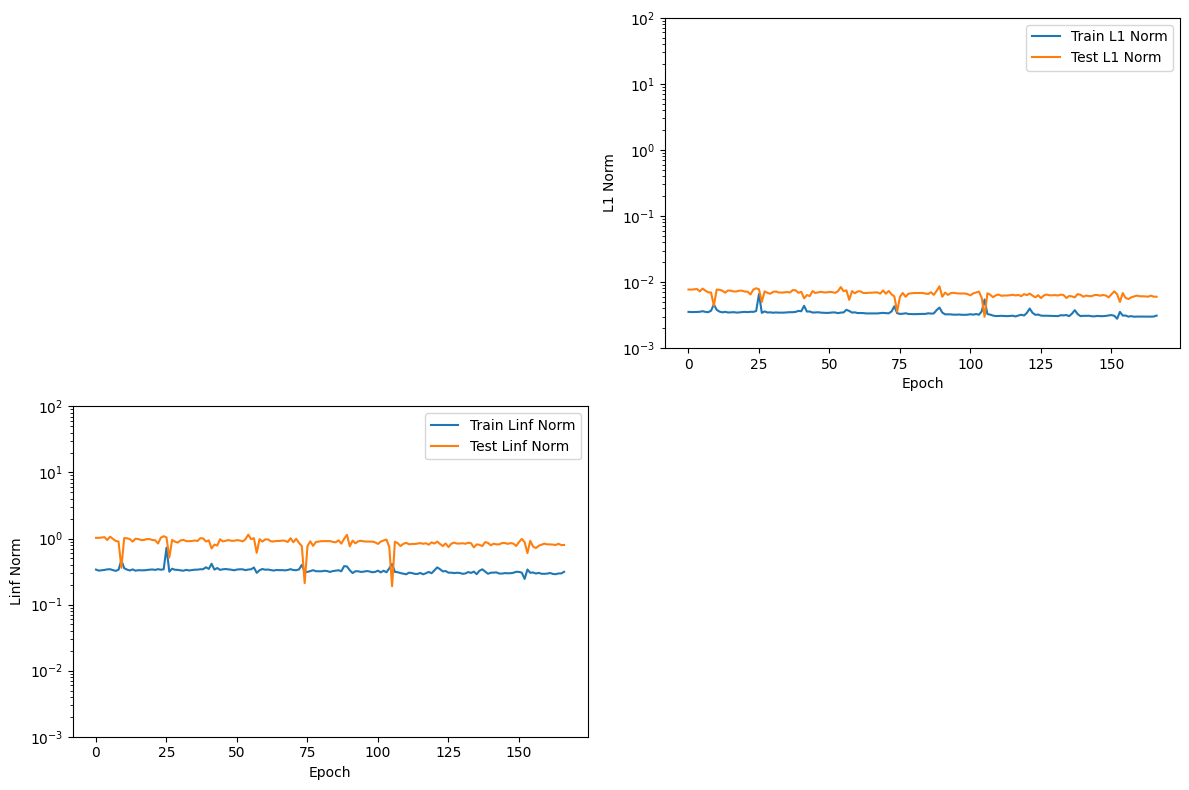

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MSE')

(1e-07, 1.0)

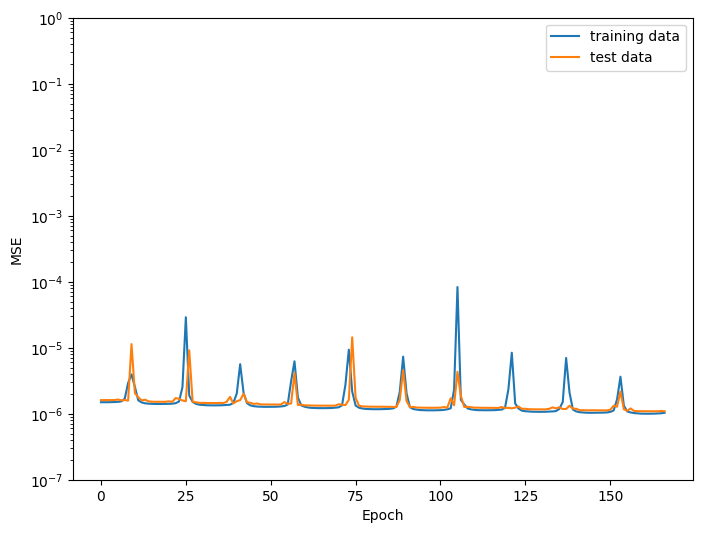

In [87]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [88]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

<All keys matched successfully>

In [89]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

164

167

'Huber'

'Adagrad'

'CosineAnnealingLR'

[1044, 914, 840]

3

'ReLU'

'ReLU'

0.0004971113311461239

ReLU()

ReLU()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=1044, bias=True)
    (1): Linear(in_features=1044, out_features=914, bias=True)
    (2): Linear(in_features=914, out_features=840, bias=True)
    (3): Linear(in_features=840, out_features=1, bias=True)
  )
)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('hidden_activation', ReLU()),
              ('output_activation', ReLU()),
              ('layers',
               ModuleList(
                 (0): Linear(in_features=3, out_features=1044, bias=True)
                 (1): Linear(in_features=1044, out_features=914, bias=True)
                 (2): Linear(in_features=914, out_features=840, bias=True)
                 (3): Linear(in_features=840, out_features

SmoothL1Loss()

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    initial_lr: 0.0004971113311461239
    lr: 0.0004243110622021168
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

{'defaults': {'lr': 0.0004971113311461239,
  'lr_decay': 0,
  'eps': 1e-10,
  'weight_decay': 0,
  'initial_accumulator_value': 0,
  'foreach': None,
  'maximize': False,
  'differentiable': False},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adagrad.zero_grad',
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[ 0.2491, -0.0154, -0.5158],
                      [-0.2211, -0.5437,  0.2490],
                      [ 0.3927,  0.5422, -0.3364],
                      ...,
                      [-0.5098,  0.0773, -0.4235],
                      [-0.1741,  0.1158, -0.2311],
                      [-0.4212,  0.0641,  0.4889]], device='cuda:0', requires_grad=True): {'step': tensor(162992.),
               'sum': tensor([[8.6594e-06, 1.1861e-06, 3.5638e-07],
                       [7.9705e-05, 3.0766e-06, 1.9596e-04],
                       [2.9655e-03, 1.1533e-02, 1.

{'T_max': 8,
 'eta_min': 0,
 'optimizer': Adagrad (
 Parameter Group 0
     differentiable: False
     eps: 1e-10
     foreach: None
     initial_accumulator_value: 0
     initial_lr: 0.0004971113311461239
     lr: 0.0004243110622021168
     lr_decay: 0
     maximize: False
     weight_decay: 0
 ),
 'base_lrs': [0.0004971113311461239],
 'last_epoch': 334,
 'verbose': False,
 '_step_count': 335,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0004243110622021168]}

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [90]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


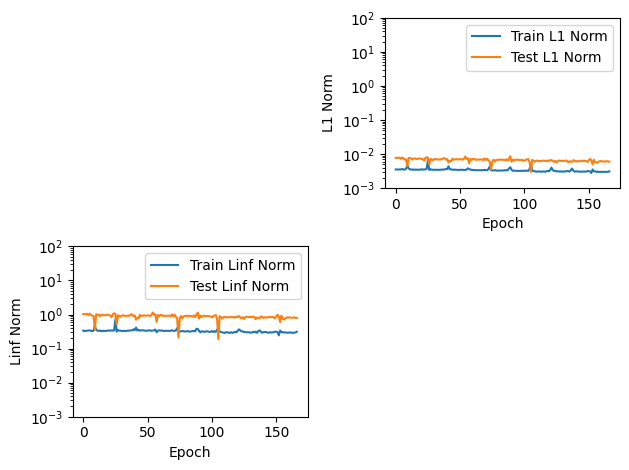

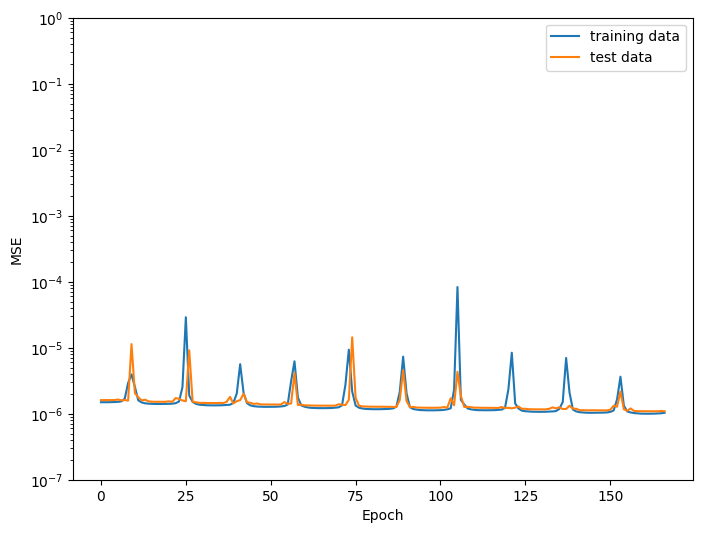

In [91]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [92]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [93]:
print(list(net.parameters()))

[Parameter containing:
tensor([[ 0.2491, -0.0154, -0.5158],
        [-0.2211, -0.5437,  0.2490],
        [ 0.3927,  0.5422, -0.3364],
        ...,
        [-0.5098,  0.0773, -0.4235],
        [-0.1741,  0.1158, -0.2311],
        [-0.4212,  0.0641,  0.4889]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.5349,  0.2851,  0.0322,  ...,  0.1765,  0.5665,  0.2583],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.0084, -0.0205,  0.0311,  ...,  0.0193,  0.0006,  0.0167],
        [ 0.0142, -0.0110,  0.0175,  ..., -0.0236, -0.0192, -0.0082],
        [ 0.0194, -0.0241,  0.0152,  ...,  0.0226, -0.0299, -0.0003],
        ...,
        [ 0.0283,  0.0114, -0.0209,  ..., -0.0059, -0.0151,  0.0089],
        [ 0.0130,  0.0149, -0.0033,  ..., -0.0183, -0.0262, -0.0195],
        [-0.0159,  0.0195,  0.0096,  ...,  0.0212,  0.0006, -0.0147]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-1.8118e-02,  2.7817e-02, -1.9838e-0

In [94]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([[ 0.2491, -0.0154, -0.5158],
        [-0.2211, -0.5437,  0.2490],
        [ 0.3927,  0.5422, -0.3364],
        ...,
        [-0.5098,  0.0773, -0.4235],
        [-0.1741,  0.1158, -0.2311],
        [-0.4212,  0.0641,  0.4889]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.5349,  0.2851,  0.0322,  ...,  0.1765,  0.5665,  0.2583],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.0084, -0.0205,  0.0311,  ...,  0.0193,  0.0006,  0.0167],
        [ 0.0142, -0.0110,  0.0175,  ..., -0.0236, -0.0192, -0.0082],
        [ 0.0194, -0.0241,  0.0152,  ...,  0.0226, -0.0299, -0.0003],
        ...,
        [ 0.0283,  0.0114, -0.0209,  ..., -0.0059, -0.0151,  0.0089],
        [ 0.0130,  0.0149, -0.0033,  ..., -0.0183, -0.0262, -0.0195],
        [-0.0159,  0.0195,  0.0096,  ...,  0.0212,  0.0006, -0.0147]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-1.8118e-02,  2.7817e-02, -1.9838e-0

In [95]:
# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=1044, bias=True)
    (1): Linear(in_features=1044, out_features=914, bias=True)
    (2): Linear(in_features=914, out_features=840, bias=True)
    (3): Linear(in_features=840, out_features=1, bias=True)
  )
)

In [96]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

tensor([[9.2391e+00, 7.6261e+00, 9.0068e+00],
        [8.7729e+00, 6.5701e+00, 1.5107e+01],
        [9.0244e+00, 2.6344e+00, 1.1228e+01],
        [6.9064e+00, 4.5420e+00, 3.4896e+00],
        [6.8061e+00, 1.0049e+01, 1.5727e+01],
        [4.0151e+00, 5.3607e+00, 4.4291e+00],
        [7.2645e+00, 3.3973e+00, 1.0916e+01],
        [5.1509e+00, 8.1000e+00, 9.8301e+00],
        [3.7517e+00, 7.6702e-01, 3.8852e+00],
        [3.4741e+00, 3.1925e-01, 2.6293e+00],
        [3.5881e-02, 6.5245e-03, 1.4835e-02],
        [7.5507e-01, 2.8364e-01, 6.7603e-01],
        [1.0444e+00, 1.7094e+00, 2.1702e+00],
        [4.7779e-01, 9.1731e-02, 1.2585e-01],
        [8.0554e-01, 4.4223e-01, 1.3920e+00],
        [1.8538e+00, 1.5641e-01, 2.9077e+00],
        [2.8811e+00, 4.0518e+00, 3.6530e+00],
        [5.4723e+00, 6.7788e+00, 9.1475e+00],
        [9.2268e+00, 1.5631e+01, 1.9276e+01],
        [5.8094e+00, 1.0021e+01, 7.2681e+00]], device='cuda:0')

In [97]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

[tensor([4.6638], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([9.3209], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([7.3443], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.5199], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([8.5634], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.4428], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([7.0164], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([4.6313], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([2.5610], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.7481], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.0095], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.4282], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.0494], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.0789], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.8919], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.9362], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.3174], device

In [98]:
# Set the network to evaluation mode
net_loaded.eval()


Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=1044, bias=True)
    (1): Linear(in_features=1044, out_features=914, bias=True)
    (2): Linear(in_features=914, out_features=840, bias=True)
    (3): Linear(in_features=840, out_features=1, bias=True)
  )
)

In [99]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

[tensor([4.6638], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([9.3209], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([7.3443], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.5199], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([8.5634], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.4428], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([7.0164], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([4.6313], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([2.5610], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.7481], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.0095], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.4282], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.0494], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.0789], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([0.8919], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.9362], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([1.3174], device

## Porting the model to C++

In [100]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)

tensor([[ 0.1797, -0.4762,  1.2668]], device='cuda:0')

tensor([[2.8595, 6.0535, 5.5984]], device='cuda:0')

tensor([[1.7028]], device='cuda:0', grad_fn=<ReluBackward0>)